# 1. Imports

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# OS
import os
import platform
import sys
import csv
from datetime import datetime

# Data
import random
import numpy as np
import pandas as pd

# TensorFlow
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, AvgPool2D, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

In [2]:
def verify_gpu_m1():
    # import os
    # import platform
    # import sys
    
    # import numpy as np
    # import pandas as pd
    # import tensorflow as tf
    # from tensorflow import keras
  
    result = pd.DataFrame(columns=['library', 'version'])
    result.loc[0] = ['Platform', platform.platform()]
    result.loc[1] = ['TensorFlow', tf.__version__]
    result.loc[2] = ['Python', str(sys.version).split(' ')[0]]
    #result.loc[3] = ['Keras', tf.keras.__version__]
    result.loc[3] = ['Pandas', pd.__version__]
    #result.loc[] = ['SkLearn', sk.__version__]
    #result.loc[] = ['SciPy', sp.__version__]
    result.loc[4] = ['Metal GPU Access', 
                     len(tf.config.list_physical_devices('GPU')) > 0]
    return result

In [3]:
print(verify_gpu_m1())

            library                     version
0          Platform  macOS-14.0-arm64-arm-64bit
1        TensorFlow                      2.13.0
2            Python                     3.10.11
3            Pandas                       1.5.3
4  Metal GPU Access                        True


In [13]:
df = pd.read_csv("BTC-USD.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [14]:
bitcoin_prices = pd.DataFrame(df["Close"]).rename(columns={"Close": "Price"})
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [18]:
timesteps = []
btc_price = []
with open("BTC-USD.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
    next(csv_reader) # skip first line (this gets rid of the column titles)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
        btc_price.append(float(line[4])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 9, 17, 0, 0),
  datetime.datetime(2014, 9, 18, 0, 0),
  datetime.datetime(2014, 9, 19, 0, 0),
  datetime.datetime(2014, 9, 20, 0, 0),
  datetime.datetime(2014, 9, 21, 0, 0),
  datetime.datetime(2014, 9, 22, 0, 0),
  datetime.datetime(2014, 9, 23, 0, 0),
  datetime.datetime(2014, 9, 24, 0, 0),
  datetime.datetime(2014, 9, 25, 0, 0),
  datetime.datetime(2014, 9, 26, 0, 0)],
 [457.334015,
  424.440002,
  394.79599,
  408.903992,
  398.821014,
  402.152008,
  435.790985,
  423.204987,
  411.574005,
  404.424988])

# 2. Helper Functions

In [36]:
def plot_time_series(timesteps, values, format='-', start=0, end=None, label=None):
    """
    Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
    
    Parameters
    ---------
    timesteps : array of timesteps
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (setting a value will index from end of timesteps & values)
    label : label to show on plot of values
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)

In [44]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data).
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # seasonality is 1 day (hence the shifting of 1 day)

    return mae / mae_naive_no_season

In [152]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)
  
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [55]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]   

In [56]:
def make_windows(x, window_size=7, horizon=1):
    """
    Turns a 1D array into a 2D array of sequential windows of window_size.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    # print(f"Window step:\n {window_step}")

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

    # 3. Index on the target array (time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels

In [64]:
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [77]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['mae']
    epochs = range(len(history.history['loss']))

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, loss, label='mae')
    plt.title('MAE')
    plt.xlabel('Epochs')
    plt.legend();

In [81]:
def make_preds(model, input_data):
    """
    Uses model to make predictions on input_data.

    Parameters
    ----------
    model: trained model 
    input_data: windowed input data (same kind of data model was trained on)

    Returns model predictions on input_data.
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return 1D array of predictions

In [160]:
def prepdata(horizon=None, window=None):
    full_windows, full_labels = make_windows(prices, window_size=window, horizon=horizon)
    train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
    #len(train_windows), len(test_windows), len(train_labels), len(test_labels)
    return train_windows, test_windows, train_labels, test_labels


In [206]:
def prepdata_multivariate(bitcoin_prices_block, horizon=None, window=None, split=0.8):
    bitcoin_prices_windowed = bitcoin_prices_block.copy()

    # Add windowed columns
    for i in range(window): # Shift values for each step in WINDOW_SIZE
        bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
    #bitcoin_prices_windowed.head(10)
    
    X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
    y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
    #X.head()

    split_size = int(len(X) * split)
    X_train, y_train = X[:split_size], y[:split_size]
    X_test, y_test = X[split_size:], y[split_size:]
    return X_train, X_test, y_train, y_test


Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE & block_reward -> HORIZON

- [0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
- [1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
- [2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]


In [229]:
X_train

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,25.00,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,25.00,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,25.00,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,25.00,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,25.00,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014
...,...,...,...,...,...,...,...,...
2021-11-02,6.25,61004.406250,61318.957031,61888.832031,62227.964844,60622.136719,58482.386719,60363.792969
2021-11-03,6.25,63226.402344,61004.406250,61318.957031,61888.832031,62227.964844,60622.136719,58482.386719
2021-11-04,6.25,62970.046875,63226.402344,61004.406250,61318.957031,61888.832031,62227.964844,60622.136719


In [231]:
bitcoin_prices_block

,Price,block_reward
Date,,
2014-09-17,457.334015,25
2014-09-18,424.440002,25
2014-09-19,394.795990,25
2014-09-20,408.903992,25
2014-09-21,398.821014,25
...,...,...
2023-08-15,29170.347656,6.25
2023-08-16,28701.779297,6.25
2023-08-17,26664.550781,6.25


# 3. Train-test split

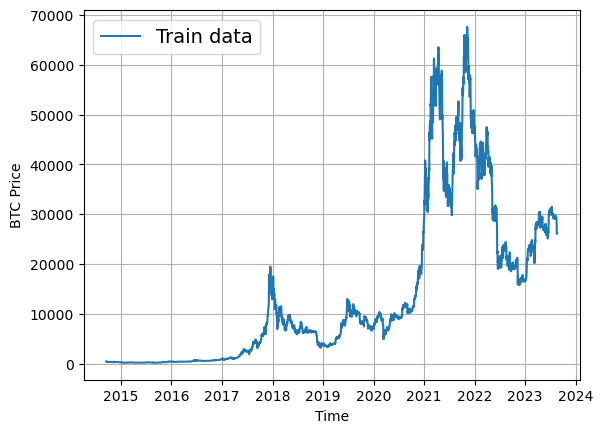

In [37]:
# bitcoin_prices.plot(figsize=(10, 7))
plot_time_series(timesteps=timesteps, values=btc_price, label="Train data")

In [22]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2607, 652, 2607, 652)

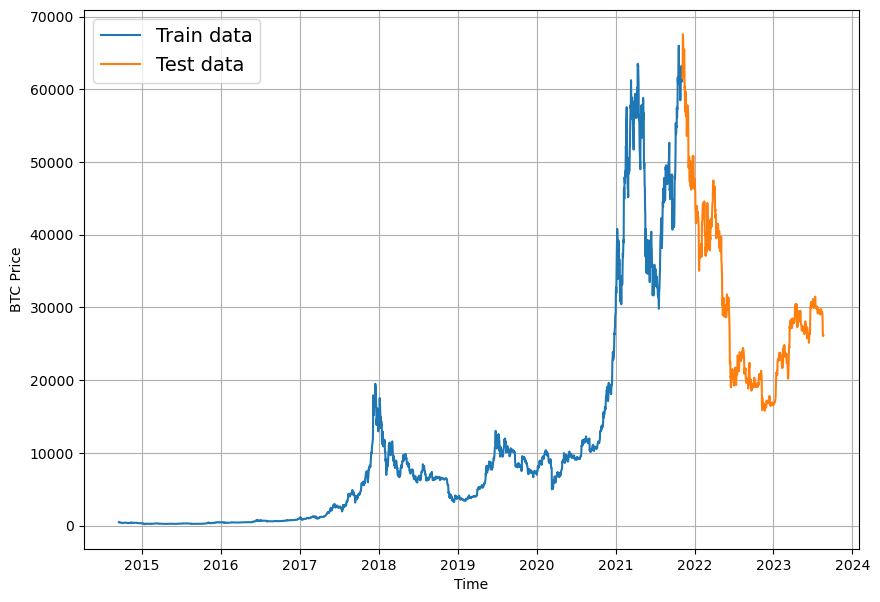

In [31]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

# 4. Experiments

### Metrics
1. MAE (mean absolute error)
2. RMSE (root mean square error)
3. MAPE (mean absolute percentage error)
4. sMAPE (symmetric mean absolute percentage error)
5. MASE (mean absolute scaled error)

* Note: MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE.

* **horizon** = number of timesteps to predict into future
* **window** = number of timesteps from past used to predict horizon

### Alternative models
1. Moving average
2. ARIMA (Autoregression Integrated Moving Average)
3. sktime (Scikit-Learn for time series)
4. TensorFlow Decision Forests (random forest, gradient boosting trees)
5. Facebook Kats (purpose-built forecasting and time series analysis library by Facebook)
6. LinkedIn Greykite

## 4.1 Naïve model (Baseline)

In [33]:
naive_model = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_model[:10], naive_model[-10:]

(array([61527.480469, 63326.988281, 67566.828125, 66971.828125,
        64995.230469, 64949.960938, 64155.941406, 64469.527344,
        65466.839844, 63557.871094]),
 array([29561.494141, 29429.591797, 29397.714844, 29415.964844,
        29282.914063, 29408.443359, 29170.347656, 28701.779297,
        26664.550781, 26049.556641]))

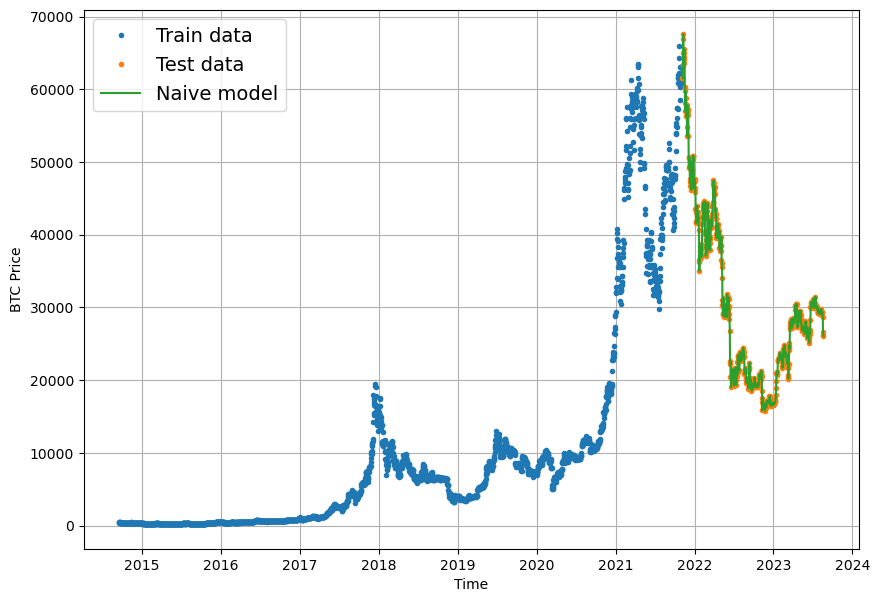

In [40]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data", format=".")
plot_time_series(timesteps=X_test, values=y_test, label="Test data", format=".")
plot_time_series(timesteps=X_test[1:], values=naive_model, format="-", label="Naive model");


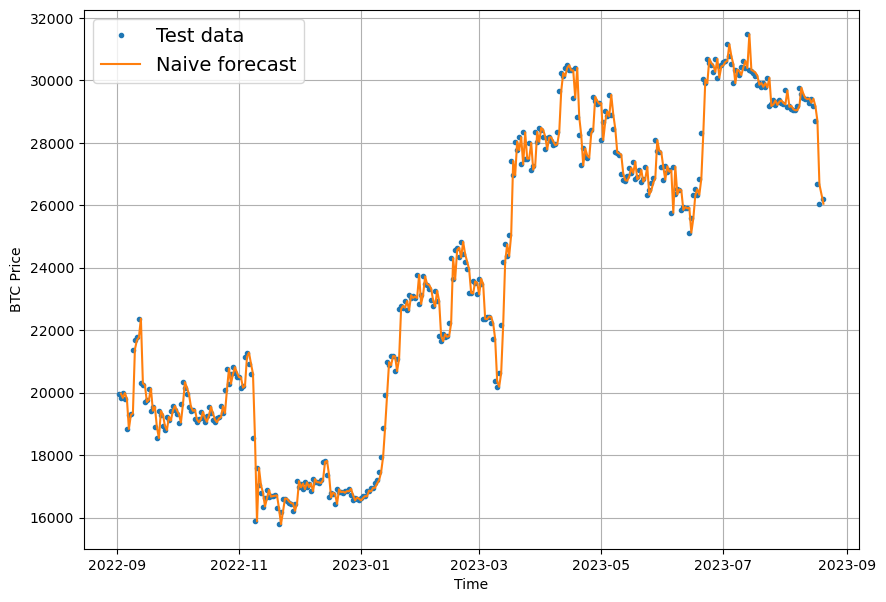

In [42]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data", format='.')
plot_time_series(timesteps=X_test[1:], values=naive_model, format="-", start=offset, label="Naive forecast");


In [49]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_model)
naive_results
     

{'mae': 627.78204,
 'mse': 976222.0,
 'rmse': 988.0395,
 'mape': 2.0496292,
 'mase': 1.0028796}

In [57]:
print('Average price of BTC in the test set (USD):', tf.reduce_mean(y_test).numpy())
print('Max price of BTC in the test set (USD):', tf.reduce_max(y_test).numpy())
print('Min price of BTC in the test set (USD):', tf.reduce_min(y_test).numpy())

Average price of BTC in the test set (USD): 29781.274896430972
Max price of BTC in the test set (USD): 67566.828125
Min price of BTC in the test set (USD): 15787.28418


## Window dataset

In [58]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [60]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")


Window: [1 2 3 4 5 6 7] -> Label: 8


In [61]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3252, 3252)

In [62]:
# View the first 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label: [423.204987]
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label: [411.574005]
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label: [404.424988]


In [63]:
# View the last 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [29429.591797 29397.714844 29415.964844 29282.914063 29408.443359
 29170.347656 28701.779297] -> Label: [26664.550781]
Window: [29397.714844 29415.964844 29282.914063 29408.443359 29170.347656
 28701.779297 26664.550781] -> Label: [26049.556641]
Window: [29415.964844 29282.914063 29408.443359 29170.347656 28701.779297
 26664.550781 26049.556641] -> Label: [26186.179688]


In [65]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)


(2601, 651, 2601, 651)

In [66]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]),
 array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

In [67]:
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

False

## Callbacks

In [68]:
def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) #

## 4.2 Dense model (window: 7, horizon: 1)

In [94]:
def model1(train_windows, train_labels, test_windows, test_labels, horizon, name):
    tf.random.set_seed(42)

    # Construct model
    model = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(horizon, activation="linear") # linear activation is the same as having no activation                        
    ], name=name) # give the model a name so we can save it

    # Compile model
    model.compile(loss="mae",
                    optimizer=tf.keras.optimizers.legacy.Adam(),
                    metrics=["mae", "mse"]) # we don't necessarily need this when the loss function is already MAE

    # Fit model
    history = model.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
                        y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
                        epochs=100,
                        verbose=1,
                        batch_size=128,
                        validation_data=(test_windows, test_labels),
                        callbacks=[create_model_checkpoint(model_name=model.name)]) # create ModelCheckpoint callback to save best model
    model.save(os.path.join('models', name))
    plot_loss_curves(history)
    return history


Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 5008.4482 - mae: 5008.4482 - mse: 163068208.0000INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 1s 23ms/step - loss: 5008.4482 - mae: 5008.4482 - mse: 163068208.0000 - val_loss: 6974.9697 - val_mae: 6974.9697 - val_mse: 113013832.0000
Epoch 2/100
18/21 [========================>.....] - ETA: 0s - loss: 1755.9625 - mae: 1755.9625 - mse: 16945582.0000INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 16ms/step - loss: 1713.6851 - mae: 1713.6851 - mse: 16393398.0000 - val_loss: 3572.4553 - val_mae: 3572.4553 - val_mse: 27299926.0000
Epoch 3/100
18/21 [========================>.....] - ETA: 0s - loss: 1302.0493 - mae: 1302.0493 - mse: 8914047.0000 INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 16ms/step - loss: 1299.3978 - mae: 1299.3978 - mse: 8890658.0000 - val_loss: 2568.9014 - val_mae: 2568.9014 - val_mse: 13587672.0000
Epoch 4/100
17/21 [=======================>......] - ETA: 0s - loss: 1196.2229 - mae: 1196.2229 - mse: 7573673.5000INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 1s 33ms/step - loss: 1161.2927 - mae: 1161.2927 - mse: 7164727.0000 - val_loss: 2353.5061 - val_mae: 2353.5061 - val_mse: 10993025.0000
Epoch 5/100
17/21 [=======================>......] - ETA: 0s - loss: 1049.0674 - mae: 1049.0674 - mse: 5919265.5000INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 16ms/step - loss: 1040.3790 - mae: 1040.3790 - mse: 5841005.5000 - val_loss: 2190.3865 - val_mae: 2190.3865 - val_mse: 9768405.0000
Epoch 6/100
17/21 [=======================>......] - ETA: 0s - loss: 929.8544 - mae: 929.8544 - mse: 4669290.0000INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 16ms/step - loss: 962.7075 - mae: 962.7075 - mse: 4950490.5000 - val_loss: 2101.1946 - val_mae: 2101.1946 - val_mse: 8112842.5000
Epoch 7/100
21/21 [==============================] - 0s 8ms/step - loss: 941.2395 - mae: 941.2395 - mse: 4655075.0000 - val_loss: 2322.3875 - val_mae: 2322.3875 - val_mse: 10841236.0000
Epoch 8/100
16/21 [=====================>........] - ETA: 0s - loss: 884.2513 - mae: 884.2513 - mse: 4259701.0000INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 17ms/step - loss: 884.9386 - mae: 884.9386 - mse: 4214737.0000 - val_loss: 2063.0972 - val_mae: 2063.0972 - val_mse: 8510399.0000
Epoch 9/100
18/21 [========================>.....] - ETA: 0s - loss: 847.4965 - mae: 847.4965 - mse: 3813112.0000INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 15ms/step - loss: 849.6041 - mae: 849.6041 - mse: 3858476.0000 - val_loss: 2029.3295 - val_mae: 2029.3295 - val_mse: 7440327.5000
Epoch 10/100
18/21 [========================>.....] - ETA: 0s - loss: 862.1002 - mae: 862.1002 - mse: 4031096.0000INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 16ms/step - loss: 851.3539 - mae: 851.3539 - mse: 3887751.7500 - val_loss: 1826.8461 - val_mae: 1826.8461 - val_mse: 6828031.0000
Epoch 11/100
17/21 [=======================>......] - ETA: 0s - loss: 829.8608 - mae: 829.8608 - mse: 3748842.5000INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 16ms/step - loss: 807.9720 - mae: 807.9720 - mse: 3531225.5000 - val_loss: 1788.3229 - val_mae: 1788.3229 - val_mse: 6176912.0000
Epoch 12/100
15/21 [====================>.........] - ETA: 0s - loss: 841.8212 - mae: 841.8212 - mse: 3760208.2500INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 17ms/step - loss: 832.7936 - mae: 832.7936 - mse: 3714378.7500 - val_loss: 1658.5984 - val_mae: 1658.5984 - val_mse: 5646291.0000
Epoch 13/100
21/21 [==============================] - 0s 8ms/step - loss: 783.8607 - mae: 783.8607 - mse: 3293616.5000 - val_loss: 1783.6151 - val_mae: 1783.6151 - val_mse: 6503731.0000
Epoch 14/100
18/21 [========================>.....] - ETA: 0s - loss: 776.5350 - mae: 776.5350 - mse: 3284037.0000INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 16ms/step - loss: 770.1858 - mae: 770.1858 - mse: 3228891.7500 - val_loss: 1644.1349 - val_mae: 1644.1349 - val_mse: 5765388.5000
Epoch 15/100
17/21 [=======================>......] - ETA: 0s - loss: 753.0140 - mae: 753.0140 - mse: 3004449.5000INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 16ms/step - loss: 758.8761 - mae: 758.8761 - mse: 3101957.7500 - val_loss: 1574.6156 - val_mae: 1574.6156 - val_mse: 5167426.5000
Epoch 16/100
21/21 [==============================] - 0s 8ms/step - loss: 757.8341 - mae: 757.8341 - mse: 3056357.5000 - val_loss: 1622.8514 - val_mae: 1622.8514 - val_mse: 5517317.0000
Epoch 17/100
21/21 [==============================] - 0s 8ms/step - loss: 744.4971 - mae: 744.4971 - mse: 2986404.0000 - val_loss: 1586.0439 - val_mae: 1586.0439 - val_mse: 5260350.5000
Epoch 18/100
21/21 [==============================] - 0s 8ms/step - loss: 772.2494 - mae: 772.2494 - mse: 3095064.0000 - val_loss: 1628.3292 - val_mae: 1628.3292 - val_mse: 5729912.0000
Epoch 19/100
21/21 [==============================] - 0s 9ms/step - loss: 733.4219 - mae: 733.4219 - mse: 2875793.5000 - val_loss: 1592.5216 - val_mae: 1592.5216 - val_mse: 5107826.5000
Epoch 20/100
21/21 [==============================] - 0s 9ms/step - loss: 730.5001

INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 16ms/step - loss: 706.5547 - mae: 706.5547 - mse: 2685080.0000 - val_loss: 1532.9299 - val_mae: 1532.9299 - val_mse: 4898151.5000
Epoch 25/100
21/21 [==============================] - 0s 8ms/step - loss: 715.6288 - mae: 715.6288 - mse: 2697689.0000 - val_loss: 1597.2517 - val_mae: 1597.2517 - val_mse: 5246734.5000
Epoch 26/100
21/21 [==============================] - 0s 8ms/step - loss: 715.9887 - mae: 715.9887 - mse: 2711884.7500 - val_loss: 2231.5686 - val_mae: 2231.5686 - val_mse: 9553150.0000
Epoch 27/100
21/21 [==============================] - 0s 9ms/step - loss: 743.2700 - mae: 743.2700 - mse: 2871357.7500 - val_loss: 1658.0576 - val_mae: 1658.0576 - val_mse: 5146863.5000
Epoch 28/100
21/21 [==============================] - 0s 9ms/step - loss: 727.1874 - mae: 727.1874 - mse: 2743845.7500 - val_loss: 1774.9110 - val_mae: 1774.9110 - val_mse: 6654714.0000
Epoch 29/100
21/21 [==============================] - 0s 9ms/step - loss: 700.0112

INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 15ms/step - loss: 722.8801 - mae: 722.8801 - mse: 2740405.2500 - val_loss: 1474.2188 - val_mae: 1474.2188 - val_mse: 4851551.0000
Epoch 31/100
21/21 [==============================] - 0s 8ms/step - loss: 680.8314 - mae: 680.8314 - mse: 2486887.7500 - val_loss: 1745.0894 - val_mae: 1745.0894 - val_mse: 6370939.0000
Epoch 32/100
21/21 [==============================] - 0s 8ms/step - loss: 697.1590 - mae: 697.1590 - mse: 2581774.5000 - val_loss: 1671.2740 - val_mae: 1671.2740 - val_mse: 5476895.0000
Epoch 33/100
15/21 [====================>.........] - ETA: 0s - loss: 692.6211 - mae: 692.6211 - mse: 2502952.0000INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 18ms/step - loss: 696.0793 - mae: 696.0793 - mse: 2576244.0000 - val_loss: 1459.8158 - val_mae: 1459.8158 - val_mse: 4670535.0000
Epoch 34/100
21/21 [==============================] - 0s 10ms/step - loss: 689.0049 - mae: 689.0049 - mse: 2531028.0000 - val_loss: 1726.1356 - val_mae: 1726.1356 - val_mse: 6739906.0000
Epoch 35/100
21/21 [==============================] - 0s 9ms/step - loss: 687.2460 - mae: 687.2460 - mse: 2564285.5000 - val_loss: 1801.9316 - val_mae: 1801.9316 - val_mse: 6542943.0000
Epoch 36/100
21/21 [==============================] - 0s 8ms/step - loss: 690.4322 - mae: 690.4322 - mse: 2560954.7500 - val_loss: 1699.7479 - val_mae: 1699.7479 - val_mse: 6264167.0000
Epoch 37/100
21/21 [==============================] - 0s 8ms/step - loss: 679.4521 - mae: 679.4521 - mse: 2461487.0000 - val_loss: 2022.5291 - val_mae: 2022.5291 - val_mse: 8655471.0000
Epoch 38/100
21/21 [==============================] - 0s 8ms/step - loss: 706.740

INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 15ms/step - loss: 691.2350 - mae: 691.2350 - mse: 2543698.5000 - val_loss: 1459.0431 - val_mae: 1459.0431 - val_mse: 4764881.0000
Epoch 41/100
21/21 [==============================] - 0s 9ms/step - loss: 664.7171 - mae: 664.7171 - mse: 2418506.5000 - val_loss: 1526.9596 - val_mae: 1526.9596 - val_mse: 4936251.5000
Epoch 42/100
21/21 [==============================] - 0s 8ms/step - loss: 672.2308 - mae: 672.2308 - mse: 2451970.5000 - val_loss: 1534.7877 - val_mae: 1534.7877 - val_mse: 5042608.0000
Epoch 43/100
21/21 [==============================] - 0s 8ms/step - loss: 689.1867 - mae: 689.1867 - mse: 2562318.0000 - val_loss: 1596.6421 - val_mae: 1596.6421 - val_mse: 5819734.5000
Epoch 44/100
21/21 [==============================] - 0s 8ms/step - loss: 676.1857 - mae: 676.1857 - mse: 2468025.0000 - val_loss: 1497.6031 - val_mae: 1497.6031 - val_mse: 4979684.0000
Epoch 45/100
21/21 [==============================] - 0s 8ms/step - loss: 681.5795

INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 15ms/step - loss: 659.7222 - mae: 659.7222 - mse: 2352358.2500 - val_loss: 1413.3026 - val_mae: 1413.3026 - val_mse: 4576542.5000
Epoch 47/100
21/21 [==============================] - 0s 8ms/step - loss: 677.3881 - mae: 677.3881 - mse: 2473035.7500 - val_loss: 1659.4785 - val_mae: 1659.4785 - val_mse: 5490280.5000
Epoch 48/100
21/21 [==============================] - 0s 8ms/step - loss: 681.2235 - mae: 681.2235 - mse: 2461749.0000 - val_loss: 1570.6442 - val_mae: 1570.6442 - val_mse: 5310447.0000
Epoch 49/100
21/21 [==============================] - 0s 8ms/step - loss: 684.1720 - mae: 684.1720 - mse: 2528911.0000 - val_loss: 1519.4655 - val_mae: 1519.4655 - val_mse: 4971727.5000
Epoch 50/100
21/21 [==============================] - 0s 8ms/step - loss: 674.2984 - mae: 674.2984 - mse: 2442304.2500 - val_loss: 1674.4565 - val_mae: 1674.4565 - val_mse: 6245298.5000
Epoch 51/100
21/21 [==============================] - 0s 8ms/step - loss: 680.4284

INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 15ms/step - loss: 704.3130 - mae: 704.3130 - mse: 2577131.5000 - val_loss: 1403.1062 - val_mae: 1403.1062 - val_mse: 4410798.0000
Epoch 57/100
21/21 [==============================] - 0s 8ms/step - loss: 667.8329 - mae: 667.8329 - mse: 2407054.7500 - val_loss: 1898.8362 - val_mae: 1898.8362 - val_mse: 7474974.5000
Epoch 58/100
21/21 [==============================] - 0s 8ms/step - loss: 670.6841 - mae: 670.6841 - mse: 2412647.2500 - val_loss: 1693.3973 - val_mae: 1693.3973 - val_mse: 6348950.5000
Epoch 59/100
21/21 [==============================] - 0s 8ms/step - loss: 669.1967 - mae: 669.1967 - mse: 2471600.7500 - val_loss: 1459.1802 - val_mae: 1459.1802 - val_mse: 4699775.5000
Epoch 60/100
21/21 [==============================] - 0s 8ms/step - loss: 690.1133 - mae: 690.1133 - mse: 2492028.5000 - val_loss: 1755.4518 - val_mae: 1755.4518 - val_mse: 6239833.5000
Epoch 61/100
21/21 [==============================] - 0s 8ms/step - loss: 673.3954

INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 15ms/step - loss: 656.3759 - mae: 656.3759 - mse: 2368547.5000 - val_loss: 1400.0791 - val_mae: 1400.0791 - val_mse: 4553679.0000
Epoch 63/100
21/21 [==============================] - 0s 8ms/step - loss: 673.0433 - mae: 673.0433 - mse: 2430754.2500 - val_loss: 1504.3649 - val_mae: 1504.3649 - val_mse: 4901684.0000
Epoch 64/100
21/21 [==============================] - 0s 8ms/step - loss: 668.5590 - mae: 668.5590 - mse: 2404924.0000 - val_loss: 1595.2815 - val_mae: 1595.2815 - val_mse: 5329280.0000
Epoch 65/100
21/21 [==============================] - 0s 8ms/step - loss: 674.2277 - mae: 674.2277 - mse: 2434459.7500 - val_loss: 1781.3533 - val_mae: 1781.3533 - val_mse: 6792249.0000
Epoch 66/100
21/21 [==============================] - 0s 7ms/step - loss: 655.5247 - mae: 655.5247 - mse: 2346008.7500 - val_loss: 1621.7557 - val_mae: 1621.7557 - val_mse: 5721045.0000
Epoch 67/100
18/21 [========================>.....] - ETA: 0s - loss: 636.4883 - m

INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 15ms/step - loss: 648.8730 - mae: 648.8730 - mse: 2296774.5000 - val_loss: 1375.8062 - val_mae: 1375.8062 - val_mse: 4368999.5000
Epoch 68/100
21/21 [==============================] - 0s 8ms/step - loss: 650.6411 - mae: 650.6411 - mse: 2324748.5000 - val_loss: 1391.4360 - val_mae: 1391.4360 - val_mse: 4381196.5000
Epoch 69/100
21/21 [==============================] - 0s 8ms/step - loss: 659.9663 - mae: 659.9663 - mse: 2368814.0000 - val_loss: 1780.0122 - val_mae: 1780.0122 - val_mse: 6376105.0000
Epoch 70/100
21/21 [==============================] - 0s 8ms/step - loss: 665.8166 - mae: 665.8166 - mse: 2402910.0000 - val_loss: 1513.2225 - val_mae: 1513.2225 - val_mse: 5048213.5000
Epoch 71/100
21/21 [==============================] - 0s 8ms/step - loss: 690.2655 - mae: 690.2655 - mse: 2518458.0000 - val_loss: 1531.5188 - val_mae: 1531.5188 - val_mse: 4611316.5000
Epoch 72/100
21/21 [==============================] - 0s 8ms/step - loss: 680.9330

INFO:tensorflow:Assets written to: model_experiments/model_1_w7h1/assets


21/21 [==============================] - 0s 15ms/step - loss: 664.7370 - mae: 664.7370 - mse: 2381938.0000 - val_loss: 1364.2994 - val_mae: 1364.2994 - val_mse: 4163106.5000
Epoch 75/100
21/21 [==============================] - 0s 7ms/step - loss: 660.5893 - mae: 660.5893 - mse: 2394964.0000 - val_loss: 1385.9012 - val_mae: 1385.9012 - val_mse: 4408735.5000
Epoch 76/100
21/21 [==============================] - 0s 7ms/step - loss: 654.8184 - mae: 654.8184 - mse: 2359943.5000 - val_loss: 1377.1836 - val_mae: 1377.1836 - val_mse: 4460670.0000
Epoch 77/100
21/21 [==============================] - 0s 7ms/step - loss: 657.7337 - mae: 657.7337 - mse: 2391215.7500 - val_loss: 1636.8618 - val_mae: 1636.8618 - val_mse: 4962145.0000
Epoch 78/100
21/21 [==============================] - 0s 7ms/step - loss: 742.3617 - mae: 742.3617 - mse: 2761597.2500 - val_loss: 1678.3969 - val_mae: 1678.3969 - val_mse: 5546037.0000
Epoch 79/100
21/21 [==============================] - 0s 7ms/step - loss: 673.0033

INFO:tensorflow:Assets written to: models/model_1_w7h1/assets


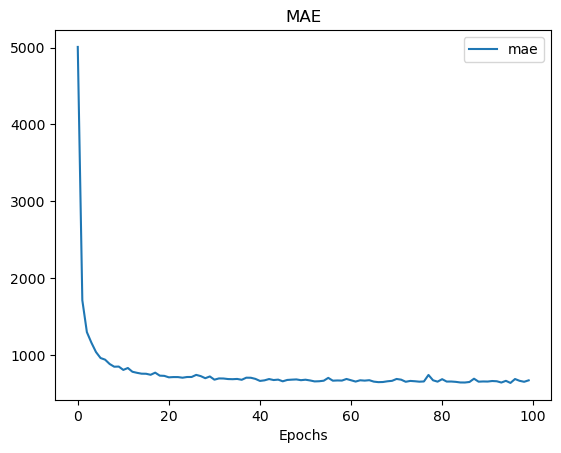

In [116]:
train_windows, test_windows, train_labels, test_labels = prepdata(1, 7)
model1(train_windows, train_labels, test_windows, test_labels, 7, 'model_1_w7h1')

In [82]:
model_1 = tf.keras.models.load_model(os.path.join('model_experiments', 'model_1_dense'))
model1.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 4ms/step - loss: 640.8933 - mae: 640.8933


[640.893310546875, 640.893310546875]

In [88]:
model_1_preds = make_preds(model_1, test_windows)
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results, naive_results

21/21 [==============================] - 0s 2ms/step


({'mae': 640.8933,
  'mse': 1016499.5,
  'rmse': 1008.216,
  'mape': 2.0886297,
  'mase': 1.0238249},
 {'mae': 627.78204,
  'mse': 976222.0,
  'rmse': 988.0395,
  'mape': 2.0496292,
  'mase': 1.0028796})

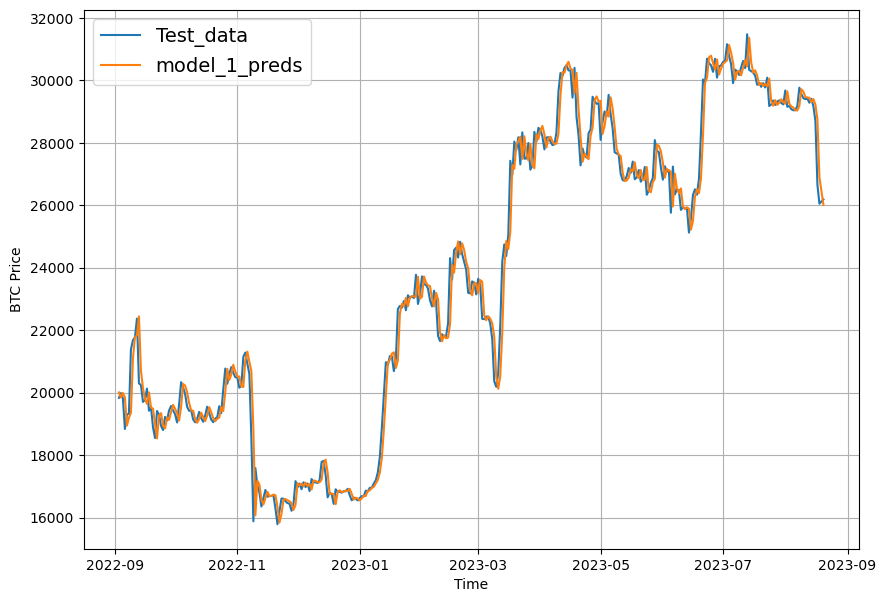

In [84]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## 4.3 Dense model (window: 30, horizon: 1)

In [121]:
train_windows, test_windows, train_labels, test_labels = prepdata(1, 30)

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 3721.8459 - mae: 3721.8459 - mse: 96556616.0000 INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


21/21 [==============================] - 1s 22ms/step - loss: 3721.8459 - mae: 3721.8459 - mse: 96556616.0000 - val_loss: 5668.8140 - val_mae: 5668.8140 - val_mse: 64046052.0000
Epoch 2/100
19/21 [==========================>...] - ETA: 0s - loss: 1428.9066 - mae: 1428.9066 - mse: 9721122.0000 INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


21/21 [==============================] - 0s 14ms/step - loss: 1402.5809 - mae: 1402.5809 - mse: 9576272.0000 - val_loss: 3002.2822 - val_mae: 3002.2822 - val_mse: 16080407.0000
Epoch 3/100
18/21 [========================>.....] - ETA: 0s - loss: 1095.8258 - mae: 1095.8258 - mse: 5984349.0000INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


21/21 [==============================] - 0s 15ms/step - loss: 1094.9526 - mae: 1094.9526 - mse: 5959384.5000 - val_loss: 2179.0400 - val_mae: 2179.0400 - val_mse: 9315985.0000
Epoch 4/100
18/21 [========================>.....] - ETA: 0s - loss: 996.4650 - mae: 996.4650 - mse: 5116227.5000  INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


21/21 [==============================] - 0s 15ms/step - loss: 982.8322 - mae: 982.8322 - mse: 4945181.5000 - val_loss: 2025.9213 - val_mae: 2025.9213 - val_mse: 7946402.5000
Epoch 5/100
21/21 [==============================] - 0s 8ms/step - loss: 911.6597 - mae: 911.6597 - mse: 4315772.5000 - val_loss: 2160.1658 - val_mae: 2160.1658 - val_mse: 8928571.0000
Epoch 6/100
17/21 [=======================>......] - ETA: 0s - loss: 834.5942 - mae: 834.5942 - mse: 3664852.2500INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


21/21 [==============================] - 0s 17ms/step - loss: 874.0383 - mae: 874.0383 - mse: 3990138.2500 - val_loss: 2008.7939 - val_mae: 2008.7939 - val_mse: 7167747.5000
Epoch 7/100
21/21 [==============================] - 0s 10ms/step - loss: 885.0302 - mae: 885.0302 - mse: 4049787.2500 - val_loss: 2028.8184 - val_mae: 2028.8184 - val_mse: 8145616.0000
Epoch 8/100
15/21 [====================>.........] - ETA: 0s - loss: 834.2495 - mae: 834.2495 - mse: 3716003.0000INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


21/21 [==============================] - 0s 17ms/step - loss: 832.1250 - mae: 832.1250 - mse: 3663095.5000 - val_loss: 1837.9597 - val_mae: 1837.9597 - val_mse: 7082676.0000
Epoch 9/100
16/21 [=====================>........] - ETA: 0s - loss: 799.8623 - mae: 799.8623 - mse: 3333492.5000INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


21/21 [==============================] - 0s 18ms/step - loss: 808.4920 - mae: 808.4920 - mse: 3396820.0000 - val_loss: 1778.4620 - val_mae: 1778.4620 - val_mse: 6053200.5000
Epoch 10/100
21/21 [==============================] - 0s 10ms/step - loss: 832.2535 - mae: 832.2535 - mse: 3714233.0000 - val_loss: 2090.9592 - val_mae: 2090.9592 - val_mse: 8749227.0000
Epoch 11/100
21/21 [==============================] - 0s 9ms/step - loss: 799.8549 - mae: 799.8549 - mse: 3419965.0000 - val_loss: 1935.0887 - val_mae: 1935.0887 - val_mse: 7021310.0000
Epoch 12/100
18/21 [========================>.....] - ETA: 0s - loss: 822.1775 - mae: 822.1775 - mse: 3612378.5000INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


21/21 [==============================] - 0s 15ms/step - loss: 836.2565 - mae: 836.2565 - mse: 3727162.2500 - val_loss: 1712.4539 - val_mae: 1712.4539 - val_mse: 6088623.5000
Epoch 13/100
21/21 [==============================] - 0s 8ms/step - loss: 771.4871 - mae: 771.4871 - mse: 3101674.7500 - val_loss: 1800.6748 - val_mae: 1800.6748 - val_mse: 6825235.5000
Epoch 14/100
17/21 [=======================>......] - ETA: 0s - loss: 755.5830 - mae: 755.5830 - mse: 3082082.5000INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


21/21 [==============================] - 0s 16ms/step - loss: 760.5988 - mae: 760.5988 - mse: 3144141.2500 - val_loss: 1590.3090 - val_mae: 1590.3090 - val_mse: 5388127.5000
Epoch 15/100
21/21 [==============================] - 0s 8ms/step - loss: 750.7274 - mae: 750.7274 - mse: 3039740.0000 - val_loss: 1612.3374 - val_mae: 1612.3374 - val_mse: 5325516.5000
Epoch 16/100
18/21 [========================>.....] - ETA: 0s - loss: 723.7104 - mae: 723.7104 - mse: 2837417.0000INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


21/21 [==============================] - 1s 33ms/step - loss: 736.8846 - mae: 736.8846 - mse: 2959010.2500 - val_loss: 1566.5734 - val_mae: 1566.5734 - val_mse: 5175529.0000
Epoch 17/100
21/21 [==============================] - 0s 9ms/step - loss: 738.8510 - mae: 738.8510 - mse: 2954708.5000 - val_loss: 1627.5029 - val_mae: 1627.5029 - val_mse: 5502918.0000
Epoch 18/100
21/21 [==============================] - 0s 10ms/step - loss: 777.9697 - mae: 777.9697 - mse: 3191865.0000 - val_loss: 1663.8397 - val_mae: 1663.8397 - val_mse: 5907932.5000
Epoch 19/100
21/21 [==============================] - 0s 8ms/step - loss: 758.6315 - mae: 758.6315 - mse: 3056346.7500 - val_loss: 1617.8499 - val_mae: 1617.8499 - val_mse: 5315481.0000
Epoch 20/100
21/21 [==============================] - 0s 8ms/step - loss: 747.6978 - mae: 747.6978 - mse: 3000278.0000 - val_loss: 1764.0715 - val_mae: 1764.0715 - val_mse: 6747919.5000
Epoch 21/100
21/21 [==============================] - 0s 7ms/step - loss: 727.979

INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


21/21 [==============================] - 0s 16ms/step - loss: 704.6304 - mae: 704.6304 - mse: 2727707.5000 - val_loss: 1532.0841 - val_mae: 1532.0841 - val_mse: 5008138.5000
Epoch 25/100
21/21 [==============================] - 0s 8ms/step - loss: 729.0391 - mae: 729.0391 - mse: 2801453.0000 - val_loss: 1815.6121 - val_mae: 1815.6121 - val_mse: 6330128.5000
Epoch 26/100
21/21 [==============================] - 0s 7ms/step - loss: 746.9133 - mae: 746.9133 - mse: 2933769.5000 - val_loss: 2259.5137 - val_mae: 2259.5137 - val_mse: 9791537.0000
Epoch 27/100
21/21 [==============================] - 0s 7ms/step - loss: 734.9658 - mae: 734.9658 - mse: 2866977.2500 - val_loss: 1620.4557 - val_mae: 1620.4557 - val_mse: 5208423.5000
Epoch 28/100
21/21 [==============================] - 0s 9ms/step - loss: 706.0786 - mae: 706.0786 - mse: 2705298.5000 - val_loss: 1700.4033 - val_mae: 1700.4033 - val_mse: 6279169.0000
Epoch 29/100
21/21 [==============================] - 0s 8ms/step - loss: 718.2282

INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


21/21 [==============================] - 0s 15ms/step - loss: 704.8050 - mae: 704.8050 - mse: 2658105.5000 - val_loss: 1507.5430 - val_mae: 1507.5430 - val_mse: 4879871.0000
Epoch 41/100
21/21 [==============================] - 0s 8ms/step - loss: 677.8168 - mae: 677.8168 - mse: 2521111.0000 - val_loss: 1512.4744 - val_mae: 1512.4744 - val_mse: 5092946.0000
Epoch 42/100
18/21 [========================>.....] - ETA: 0s - loss: 682.1516 - mae: 682.1516 - mse: 2531614.5000INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


21/21 [==============================] - 0s 15ms/step - loss: 688.5168 - mae: 688.5168 - mse: 2607754.2500 - val_loss: 1476.1462 - val_mae: 1476.1462 - val_mse: 4678027.5000
Epoch 43/100
21/21 [==============================] - 0s 8ms/step - loss: 684.7449 - mae: 684.7449 - mse: 2582857.0000 - val_loss: 1820.3998 - val_mae: 1820.3998 - val_mse: 6628184.0000
Epoch 44/100
21/21 [==============================] - 0s 8ms/step - loss: 685.9899 - mae: 685.9899 - mse: 2552998.7500 - val_loss: 1637.0376 - val_mae: 1637.0376 - val_mse: 5843834.0000
Epoch 45/100
21/21 [==============================] - 0s 8ms/step - loss: 701.1100 - mae: 701.1100 - mse: 2599030.2500 - val_loss: 1777.8744 - val_mae: 1777.8744 - val_mse: 6472799.5000
Epoch 46/100
19/21 [==========================>...] - ETA: 0s - loss: 695.7062 - mae: 695.7062 - mse: 2574354.0000INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


21/21 [==============================] - 0s 14ms/step - loss: 699.9395 - mae: 699.9395 - mse: 2622632.2500 - val_loss: 1438.8893 - val_mae: 1438.8893 - val_mse: 4574206.0000
Epoch 47/100
21/21 [==============================] - 0s 7ms/step - loss: 686.4417 - mae: 686.4417 - mse: 2565012.0000 - val_loss: 1747.3754 - val_mae: 1747.3754 - val_mse: 6679554.5000
Epoch 48/100
21/21 [==============================] - 0s 7ms/step - loss: 678.7266 - mae: 678.7266 - mse: 2514168.7500 - val_loss: 1461.8118 - val_mae: 1461.8118 - val_mse: 4818683.5000
Epoch 49/100
21/21 [==============================] - 0s 8ms/step - loss: 676.4153 - mae: 676.4153 - mse: 2512959.7500 - val_loss: 1470.0570 - val_mae: 1470.0570 - val_mse: 4737232.0000
Epoch 50/100
21/21 [==============================] - 0s 8ms/step - loss: 678.1418 - mae: 678.1418 - mse: 2511045.7500 - val_loss: 1656.0046 - val_mae: 1656.0046 - val_mse: 6362973.5000
Epoch 51/100
21/21 [==============================] - 0s 8ms/step - loss: 692.2647

INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


21/21 [==============================] - 0s 15ms/step - loss: 662.6364 - mae: 662.6364 - mse: 2393456.5000 - val_loss: 1430.0991 - val_mae: 1430.0991 - val_mse: 4650353.0000
Epoch 69/100
21/21 [==============================] - 0s 8ms/step - loss: 663.9190 - mae: 663.9190 - mse: 2434564.2500 - val_loss: 1493.0447 - val_mae: 1493.0447 - val_mse: 5025005.0000
Epoch 70/100
21/21 [==============================] - 0s 7ms/step - loss: 658.9033 - mae: 658.9033 - mse: 2411575.5000 - val_loss: 1797.9841 - val_mae: 1797.9841 - val_mse: 6447833.0000
Epoch 71/100
21/21 [==============================] - 0s 8ms/step - loss: 720.6176 - mae: 720.6176 - mse: 2686533.0000 - val_loss: 1517.0840 - val_mae: 1517.0840 - val_mse: 4599144.5000
Epoch 72/100
21/21 [==============================] - 0s 8ms/step - loss: 683.3288 - mae: 683.3288 - mse: 2519429.7500 - val_loss: 1580.9398 - val_mae: 1580.9398 - val_mse: 4814915.5000
Epoch 73/100
21/21 [==============================] - 0s 8ms/step - loss: 671.3030

INFO:tensorflow:Assets written to: model_experiments/model_2_w30h1/assets


21/21 [==============================] - 0s 15ms/step - loss: 674.3447 - mae: 674.3447 - mse: 2433603.2500 - val_loss: 1364.0011 - val_mae: 1364.0011 - val_mse: 4344838.0000
Epoch 83/100
21/21 [==============================] - 0s 8ms/step - loss: 646.6992 - mae: 646.6992 - mse: 2314402.0000 - val_loss: 1615.0637 - val_mae: 1615.0637 - val_mse: 5794151.5000
Epoch 84/100
21/21 [==============================] - 0s 8ms/step - loss: 653.5444 - mae: 653.5444 - mse: 2350767.0000 - val_loss: 1505.3201 - val_mae: 1505.3201 - val_mse: 4993972.0000
Epoch 85/100
21/21 [==============================] - 0s 8ms/step - loss: 667.8865 - mae: 667.8865 - mse: 2455528.5000 - val_loss: 1514.1367 - val_mae: 1514.1367 - val_mse: 4886517.5000
Epoch 86/100
21/21 [==============================] - 0s 9ms/step - loss: 660.5477 - mae: 660.5477 - mse: 2397509.0000 - val_loss: 1395.6628 - val_mae: 1395.6628 - val_mse: 4544913.5000
Epoch 87/100
21/21 [==============================] - 0s 9ms/step - loss: 643.5692

INFO:tensorflow:Assets written to: models/model_2_w30h1/assets


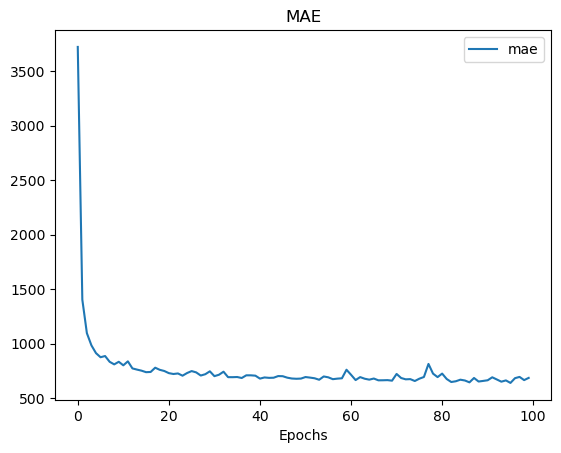

In [122]:
model1(train_windows, train_labels, test_windows, test_labels, HORIZON, 'model_2_w30h1')

In [119]:
model_2_w30h1 = tf.keras.models.load_model(os.path.join('model_experiments', 'model_2_w30h1'))
model_2_w30h1.evaluate(test_windows, test_labels)

model_2_preds = make_preds(model_2_w30h1, test_windows)
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results, naive_results

21/21 [==============================] - 0s 2ms/step


({'mae': 1381.2448,
  'mse': 4141096.5,
  'rmse': 1585.5717,
  'mape': 4.6315284,
  'mase': 2.2271464},
 {'mae': 627.78204,
  'mse': 976222.0,
  'rmse': 988.0395,
  'mape': 2.0496292,
  'mase': 1.0028796})

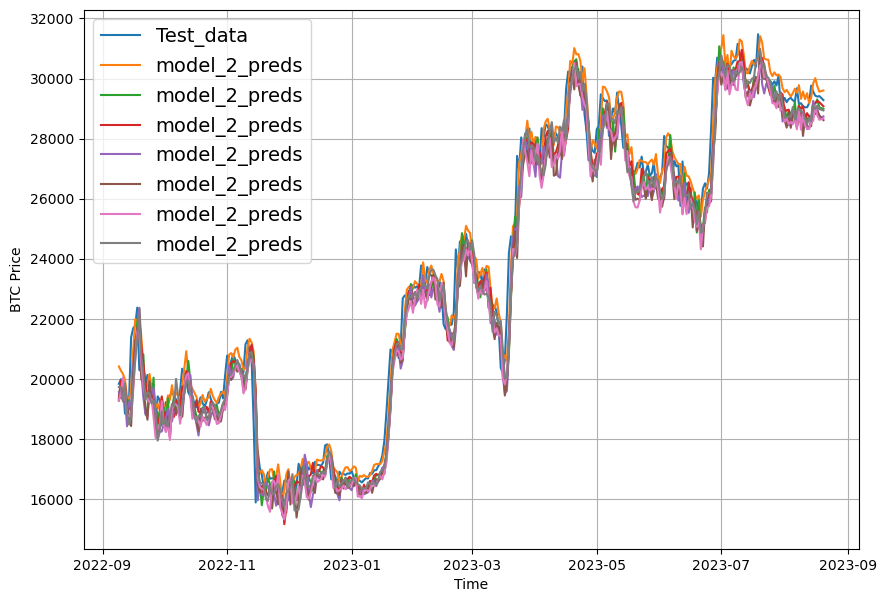

In [120]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_2_preds, start=offset, 
                 format="-", label="model_2_preds")



## 4.4 Dense model (window: 30, horizon: 7)

In [123]:
HORIZON = 7
WINDOW_SIZE = 30

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 4313.8076 - mae: 4313.8076 - mse: 129697536.0000INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 1s 22ms/step - loss: 4313.8076 - mae: 4313.8076 - mse: 129697536.0000 - val_loss: 7016.6621 - val_mae: 7016.6621 - val_mse: 105999984.0000
Epoch 2/100
16/21 [=====================>........] - ETA: 0s - loss: 1647.2581 - mae: 1647.2581 - mse: 13289057.0000INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 16ms/step - loss: 1560.3496 - mae: 1560.3496 - mse: 12248752.0000 - val_loss: 3705.1555 - val_mae: 3705.1555 - val_mse: 27394438.0000
Epoch 3/100
18/21 [========================>.....] - ETA: 0s - loss: 1211.2888 - mae: 1211.2888 - mse: 7355791.5000INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 14ms/step - loss: 1208.3739 - mae: 1208.3739 - mse: 7301059.0000 - val_loss: 2596.5920 - val_mae: 2596.5920 - val_mse: 13241589.0000
Epoch 4/100
18/21 [========================>.....] - ETA: 0s - loss: 1105.1694 - mae: 1105.1694 - mse: 6232539.5000INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 14ms/step - loss: 1089.2972 - mae: 1089.2972 - mse: 6024572.5000 - val_loss: 2216.3281 - val_mae: 2216.3281 - val_mse: 9637560.0000
Epoch 5/100
17/21 [=======================>......] - ETA: 0s - loss: 992.9673 - mae: 992.9673 - mse: 5091424.0000  INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 16ms/step - loss: 987.5619 - mae: 987.5619 - mse: 5007051.5000 - val_loss: 2095.3821 - val_mae: 2095.3821 - val_mse: 8541433.0000
Epoch 6/100
16/21 [=====================>........] - ETA: 0s - loss: 892.6682 - mae: 892.6682 - mse: 4043404.2500INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 15ms/step - loss: 927.7584 - mae: 927.7584 - mse: 4419446.5000 - val_loss: 2089.9087 - val_mae: 2089.9087 - val_mse: 7811371.5000
Epoch 7/100
21/21 [==============================] - 0s 8ms/step - loss: 938.7019 - mae: 938.7019 - mse: 4424722.5000 - val_loss: 2266.6057 - val_mae: 2266.6057 - val_mse: 9866310.0000
Epoch 8/100
19/21 [==========================>...] - ETA: 0s - loss: 874.6406 - mae: 874.6406 - mse: 3992668.2500INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 14ms/step - loss: 876.9949 - mae: 876.9949 - mse: 4014566.5000 - val_loss: 2017.7517 - val_mae: 2017.7517 - val_mse: 8247841.5000
Epoch 9/100
17/21 [=======================>......] - ETA: 0s - loss: 850.4471 - mae: 850.4471 - mse: 3761107.7500INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 16ms/step - loss: 858.0256 - mae: 858.0256 - mse: 3817477.2500 - val_loss: 1992.4020 - val_mae: 1992.4020 - val_mse: 7216064.5000
Epoch 10/100
21/21 [==============================] - 0s 8ms/step - loss: 857.1881 - mae: 857.1881 - mse: 3869991.5000 - val_loss: 2018.9413 - val_mae: 2018.9413 - val_mse: 8302878.0000
Epoch 11/100
21/21 [==============================] - 0s 8ms/step - loss: 841.5993 - mae: 841.5993 - mse: 3719398.0000 - val_loss: 2010.5663 - val_mae: 2010.5663 - val_mse: 7390427.0000
Epoch 12/100
17/21 [=======================>......] - ETA: 0s - loss: 826.8759 - mae: 826.8759 - mse: 3619218.0000INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 16ms/step - loss: 834.8435 - mae: 834.8435 - mse: 3679726.5000 - val_loss: 1918.5806 - val_mae: 1918.5806 - val_mse: 7273104.5000
Epoch 13/100
21/21 [==============================] - 0s 8ms/step - loss: 834.4370 - mae: 834.4370 - mse: 3572053.2500 - val_loss: 2015.1957 - val_mae: 2015.1957 - val_mse: 7531159.0000
Epoch 14/100
19/21 [==========================>...] - ETA: 0s - loss: 800.6033 - mae: 800.6033 - mse: 3422453.2500INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 14ms/step - loss: 804.8137 - mae: 804.8137 - mse: 3428242.0000 - val_loss: 1750.9185 - val_mae: 1750.9185 - val_mse: 6164768.5000
Epoch 15/100
18/21 [========================>.....] - ETA: 0s - loss: 790.6843 - mae: 790.6843 - mse: 3291571.0000INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 15ms/step - loss: 784.6988 - mae: 784.6988 - mse: 3272781.5000 - val_loss: 1650.3672 - val_mae: 1650.3672 - val_mse: 5577204.0000
Epoch 16/100
21/21 [==============================] - 0s 9ms/step - loss: 780.8499 - mae: 780.8499 - mse: 3245107.5000 - val_loss: 1708.0360 - val_mae: 1708.0360 - val_mse: 5824137.5000
Epoch 17/100
18/21 [========================>.....] - ETA: 0s - loss: 781.7405 - mae: 781.7405 - mse: 3244851.2500INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 15ms/step - loss: 780.2680 - mae: 780.2680 - mse: 3230995.5000 - val_loss: 1646.2915 - val_mae: 1646.2915 - val_mse: 5622916.0000
Epoch 18/100
21/21 [==============================] - 0s 8ms/step - loss: 790.6998 - mae: 790.6998 - mse: 3271534.7500 - val_loss: 1692.3984 - val_mae: 1692.3984 - val_mse: 6125685.5000
Epoch 19/100
15/21 [====================>.........] - ETA: 0s - loss: 795.7943 - mae: 795.7943 - mse: 3349643.7500INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 16ms/step - loss: 764.7553 - mae: 764.7553 - mse: 3137638.2500 - val_loss: 1602.0562 - val_mae: 1602.0562 - val_mse: 5401147.5000
Epoch 20/100
21/21 [==============================] - 0s 8ms/step - loss: 744.0187 - mae: 744.0187 - mse: 2985418.2500 - val_loss: 1606.3660 - val_mae: 1606.3660 - val_mse: 5648360.5000
Epoch 21/100
21/21 [==============================] - 0s 9ms/step - loss: 736.9494 - mae: 736.9494 - mse: 2924579.2500 - val_loss: 1804.9436 - val_mae: 1804.9436 - val_mse: 6723990.5000
Epoch 22/100
21/21 [==============================] - 0s 9ms/step - loss: 739.4702 - mae: 739.4702 - mse: 2931506.0000 - val_loss: 2023.1952 - val_mae: 2023.1952 - val_mse: 8458288.0000
Epoch 23/100
21/21 [==============================] - 0s 9ms/step - loss: 736.0255 - mae: 736.0255 - mse: 2938645.5000 - val_loss: 1784.5870 - val_mae: 1784.5870 - val_mse: 6601719.5000
Epoch 24/100
17/21 [=======================>......] - ETA: 0s - loss: 733.3892 - m

INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 16ms/step - loss: 731.8231 - mae: 731.8231 - mse: 2867427.5000 - val_loss: 1589.8242 - val_mae: 1589.8242 - val_mse: 5349248.5000
Epoch 25/100
21/21 [==============================] - 0s 9ms/step - loss: 741.7593 - mae: 741.7593 - mse: 2869917.2500 - val_loss: 1672.1497 - val_mae: 1672.1497 - val_mse: 5396492.0000
Epoch 26/100
21/21 [==============================] - 0s 9ms/step - loss: 727.5160 - mae: 727.5160 - mse: 2832909.0000 - val_loss: 1894.3508 - val_mae: 1894.3508 - val_mse: 7484651.0000
Epoch 27/100
21/21 [==============================] - 0s 8ms/step - loss: 739.1192 - mae: 739.1192 - mse: 2885305.7500 - val_loss: 1683.2025 - val_mae: 1683.2025 - val_mse: 5398216.5000
Epoch 28/100
21/21 [==============================] - 0s 8ms/step - loss: 720.6354 - mae: 720.6354 - mse: 2743968.0000 - val_loss: 1853.3536 - val_mae: 1853.3536 - val_mse: 7216762.0000
Epoch 29/100
21/21 [==============================] - 0s 9ms/step - loss: 724.7354

INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 15ms/step - loss: 751.5908 - mae: 751.5908 - mse: 2905902.7500 - val_loss: 1584.0497 - val_mae: 1584.0497 - val_mse: 5488732.0000
Epoch 31/100
21/21 [==============================] - 0s 7ms/step - loss: 713.1868 - mae: 713.1868 - mse: 2707269.5000 - val_loss: 1720.0264 - val_mae: 1720.0264 - val_mse: 6449535.0000
Epoch 32/100
21/21 [==============================] - 0s 8ms/step - loss: 724.4805 - mae: 724.4805 - mse: 2787838.5000 - val_loss: 1743.0887 - val_mae: 1743.0887 - val_mse: 5680048.5000
Epoch 33/100
21/21 [==============================] - 0s 8ms/step - loss: 725.7747 - mae: 725.7747 - mse: 2783356.5000 - val_loss: 1653.7896 - val_mae: 1653.7896 - val_mse: 5665138.0000
Epoch 34/100
21/21 [==============================] - 0s 8ms/step - loss: 710.7408 - mae: 710.7408 - mse: 2707270.7500 - val_loss: 1797.1930 - val_mae: 1797.1930 - val_mse: 6752590.0000
Epoch 35/100
21/21 [==============================] - 0s 8ms/step - loss: 704.0978

INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 15ms/step - loss: 712.9394 - mae: 712.9394 - mse: 2652242.5000 - val_loss: 1573.2640 - val_mae: 1573.2640 - val_mse: 5359150.5000
Epoch 39/100
21/21 [==============================] - 0s 8ms/step - loss: 702.1879 - mae: 702.1879 - mse: 2604832.2500 - val_loss: 1974.4410 - val_mae: 1974.4410 - val_mse: 7448835.5000
Epoch 40/100
19/21 [==========================>...] - ETA: 0s - loss: 697.5529 - mae: 697.5529 - mse: 2618596.5000INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 14ms/step - loss: 690.2845 - mae: 690.2845 - mse: 2581264.0000 - val_loss: 1481.1942 - val_mae: 1481.1942 - val_mse: 4645183.5000
Epoch 41/100
21/21 [==============================] - 0s 8ms/step - loss: 687.5172 - mae: 687.5172 - mse: 2555231.5000 - val_loss: 1504.8630 - val_mae: 1504.8630 - val_mse: 4697124.5000
Epoch 42/100
20/21 [===========================>..] - ETA: 0s - loss: 683.8663 - mae: 683.8663 - mse: 2562519.2500INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 14ms/step - loss: 683.4478 - mae: 683.4478 - mse: 2552521.5000 - val_loss: 1451.7672 - val_mae: 1451.7672 - val_mse: 4515085.5000
Epoch 43/100
21/21 [==============================] - 0s 8ms/step - loss: 683.9098 - mae: 683.9098 - mse: 2546610.2500 - val_loss: 1584.6968 - val_mae: 1584.6968 - val_mse: 5688952.5000
Epoch 44/100
20/21 [===========================>..] - ETA: 0s - loss: 680.0396 - mae: 680.0396 - mse: 2524435.2500INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 1s 32ms/step - loss: 681.0843 - mae: 681.0843 - mse: 2525645.5000 - val_loss: 1447.7397 - val_mae: 1447.7397 - val_mse: 4718941.5000
Epoch 45/100
21/21 [==============================] - 0s 8ms/step - loss: 698.4404 - mae: 698.4404 - mse: 2549764.7500 - val_loss: 1564.6486 - val_mae: 1564.6486 - val_mse: 5387125.0000
Epoch 46/100
18/21 [========================>.....] - ETA: 0s - loss: 679.0964 - mae: 679.0964 - mse: 2496738.5000INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 15ms/step - loss: 676.9918 - mae: 676.9918 - mse: 2512492.7500 - val_loss: 1402.0201 - val_mae: 1402.0201 - val_mse: 4509905.0000
Epoch 47/100
21/21 [==============================] - 0s 8ms/step - loss: 673.0071 - mae: 673.0071 - mse: 2495635.7500 - val_loss: 1629.8529 - val_mae: 1629.8529 - val_mse: 5678341.0000
Epoch 48/100
21/21 [==============================] - 0s 8ms/step - loss: 692.8007 - mae: 692.8007 - mse: 2539715.0000 - val_loss: 1648.1632 - val_mae: 1648.1632 - val_mse: 5650683.0000
Epoch 49/100
21/21 [==============================] - 0s 8ms/step - loss: 701.7463 - mae: 701.7463 - mse: 2614476.7500 - val_loss: 1648.8932 - val_mae: 1648.8932 - val_mse: 5981600.5000
Epoch 50/100
21/21 [==============================] - 0s 7ms/step - loss: 686.2229 - mae: 686.2229 - mse: 2545890.5000 - val_loss: 1576.4001 - val_mae: 1576.4001 - val_mse: 5634453.5000
Epoch 51/100
21/21 [==============================] - 0s 7ms/step - loss: 693.7581

INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 14ms/step - loss: 665.8488 - mae: 665.8488 - mse: 2419378.0000 - val_loss: 1385.6362 - val_mae: 1385.6362 - val_mse: 4231476.0000
Epoch 75/100
21/21 [==============================] - 0s 7ms/step - loss: 660.8909 - mae: 660.8909 - mse: 2415449.0000 - val_loss: 1546.1609 - val_mae: 1546.1609 - val_mse: 5272052.5000
Epoch 76/100
21/21 [==============================] - 0s 7ms/step - loss: 657.1694 - mae: 657.1694 - mse: 2376093.0000 - val_loss: 1614.3218 - val_mae: 1614.3218 - val_mse: 5844852.5000
Epoch 77/100
21/21 [==============================] - 0s 8ms/step - loss: 684.0027 - mae: 684.0027 - mse: 2519591.0000 - val_loss: 1731.4969 - val_mae: 1731.4969 - val_mse: 5547474.5000
Epoch 78/100
21/21 [==============================] - 0s 7ms/step - loss: 764.1871 - mae: 764.1871 - mse: 2911077.7500 - val_loss: 1741.8062 - val_mae: 1741.8062 - val_mse: 5660942.5000
Epoch 79/100
21/21 [==============================] - 0s 7ms/step - loss: 689.9957

INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 14ms/step - loss: 653.4026 - mae: 653.4026 - mse: 2335283.2500 - val_loss: 1364.6086 - val_mae: 1364.6086 - val_mse: 4217605.0000
Epoch 83/100
21/21 [==============================] - 0s 8ms/step - loss: 649.8235 - mae: 649.8235 - mse: 2330044.7500 - val_loss: 1775.2738 - val_mae: 1775.2738 - val_mse: 6725017.0000
Epoch 84/100
21/21 [==============================] - 0s 7ms/step - loss: 655.8452 - mae: 655.8452 - mse: 2342192.2500 - val_loss: 1517.8036 - val_mae: 1517.8036 - val_mse: 5289315.0000
Epoch 85/100
21/21 [==============================] - 0s 7ms/step - loss: 667.2940 - mae: 667.2940 - mse: 2450137.7500 - val_loss: 1513.3397 - val_mae: 1513.3397 - val_mse: 4790780.5000
Epoch 86/100
21/21 [==============================] - 0s 7ms/step - loss: 671.6893 - mae: 671.6893 - mse: 2437006.5000 - val_loss: 1401.7650 - val_mae: 1401.7650 - val_mse: 4511841.0000
Epoch 87/100
21/21 [==============================] - 0s 7ms/step - loss: 649.3582

INFO:tensorflow:Assets written to: model_experiments/model_3_w30h7/assets


21/21 [==============================] - 0s 14ms/step - loss: 646.9119 - mae: 646.9119 - mse: 2314596.5000 - val_loss: 1356.7864 - val_mae: 1356.7864 - val_mse: 4209011.5000
Epoch 91/100
21/21 [==============================] - 0s 7ms/step - loss: 652.8454 - mae: 652.8454 - mse: 2344602.5000 - val_loss: 1980.7665 - val_mae: 1980.7665 - val_mse: 7353648.0000
Epoch 92/100
21/21 [==============================] - 0s 7ms/step - loss: 668.9899 - mae: 668.9899 - mse: 2401065.0000 - val_loss: 1724.2159 - val_mae: 1724.2159 - val_mse: 6173958.5000
Epoch 93/100
21/21 [==============================] - 0s 8ms/step - loss: 674.1694 - mae: 674.1694 - mse: 2444272.7500 - val_loss: 1402.8549 - val_mae: 1402.8549 - val_mse: 4241607.0000
Epoch 94/100
21/21 [==============================] - 0s 8ms/step - loss: 637.1975 - mae: 637.1975 - mse: 2258104.0000 - val_loss: 1462.5430 - val_mae: 1462.5430 - val_mse: 4621123.0000
Epoch 95/100
21/21 [==============================] - 0s 8ms/step - loss: 660.5620

INFO:tensorflow:Assets written to: models/model_3_w30h7/assets


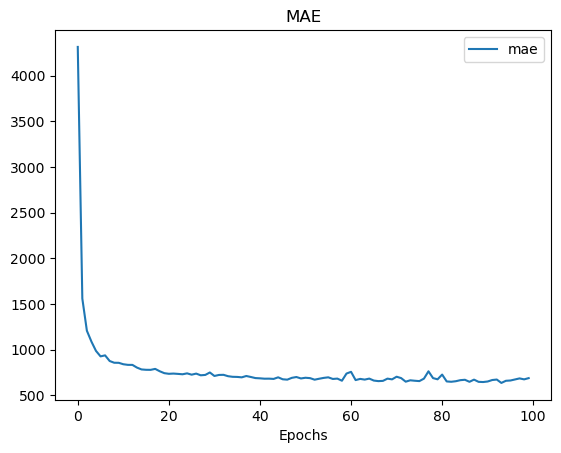

In [142]:
train_windows, test_windows, train_labels, test_labels = prepdata(7, 30)
model1(train_windows, train_labels, test_windows, test_labels, HORIZON, 'model_3_w30h7')

In [125]:
model_3_w30h1 = tf.keras.models.load_model(os.path.join('model_experiments', 'model_3_w30h7'))
model_3_w30h1.evaluate(test_windows, test_labels)

model_3_preds = make_preds(model_3_w30h1, test_windows)
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results, naive_results

21/21 [==============================] - 0s 2ms/step


({'mae': 1393.6893,
  'mse': 4441545.0,
  'rmse': 1619.5697,
  'mape': 4.642878,
  'mase': 2.2472124},
 {'mae': 627.78204,
  'mse': 976222.0,
  'rmse': 988.0395,
  'mape': 2.0496292,
  'mase': 1.0028796})

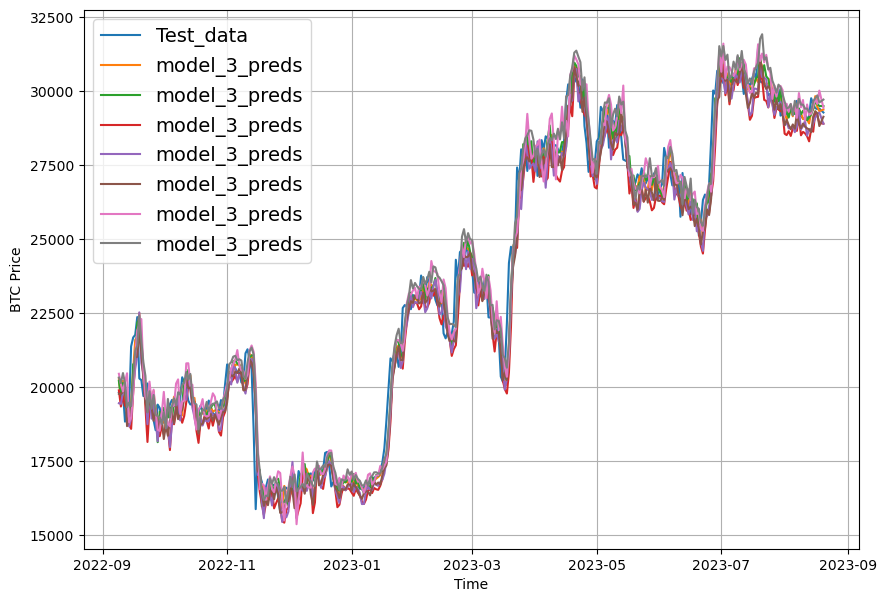

In [126]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")


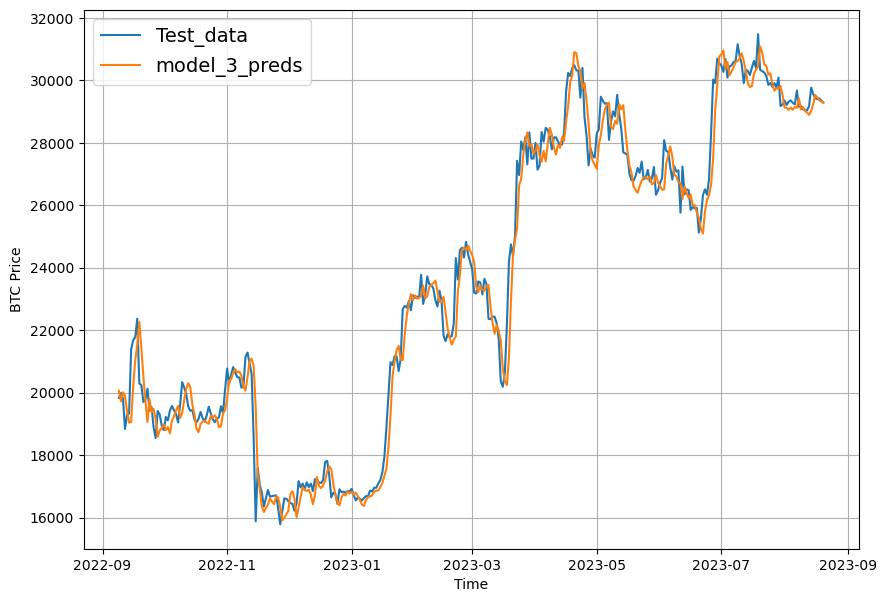

In [143]:
offset = 300
plt.figure(figsize=(10, 7))
# will condense information so the preds will look fruther ahead than the test data
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

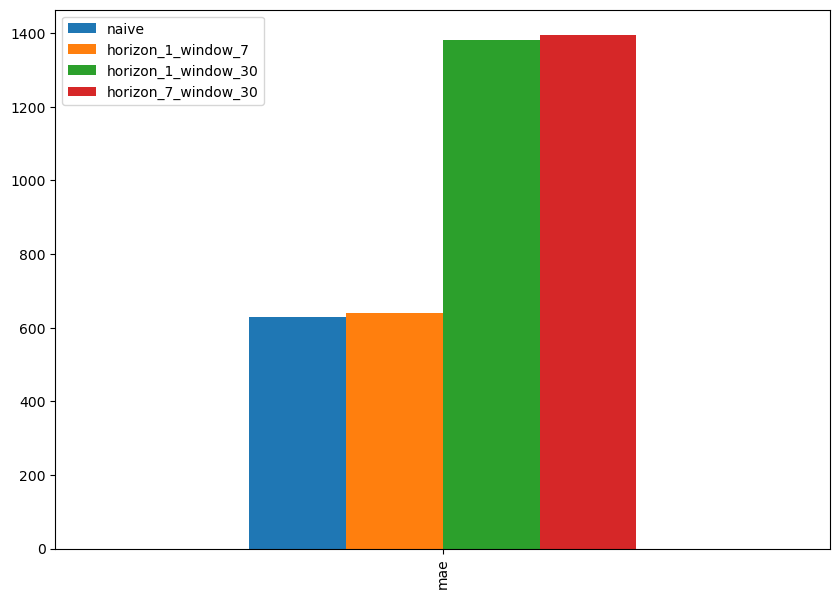

In [127]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");
     

## 4.4 Conv1D (window: 7, horizon: 1)

In [180]:
def conv1d(train_windows, train_labels, test_windows, test_labels, name, window=None, horizon=None):
    tf.random.set_seed(42)

    # Construct model
    model = tf.keras.Sequential([
    # Create Lambda layer to reshape inputs
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(horizon)], name="model_4_conv1D")

    # Compile model
    model.compile(loss="mae",
                    optimizer=tf.keras.optimizers.legacy.Adam(),
                    metrics=["mae", "mse"]) # we don't necessarily need this when the loss function is already MAE
    #model.summary()
    # Fit model
    history = model.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
                        y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
                        epochs=100,
                        verbose=1,
                        batch_size=128,
                        validation_data=(test_windows, test_labels),
                        callbacks=[create_model_checkpoint(model_name=model.name)]) # create ModelCheckpoint callback to save best model
    model.save(os.path.join('models', name))
    plot_loss_curves(history)
    return history

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 4141.2793 - mae: 4141.2793 - mse: 81901864.0000INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 1s 29ms/step - loss: 4141.2793 - mae: 4141.2793 - mse: 81901864.0000 - val_loss: 4820.0703 - val_mae: 4820.0703 - val_mse: 30026838.0000
Epoch 2/100
15/21 [====================>.........] - ETA: 0s - loss: 990.6896 - mae: 990.6896 - mse: 4403514.5000  INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 19ms/step - loss: 921.1400 - mae: 921.1400 - mse: 3881698.5000 - val_loss: 1093.2258 - val_mae: 1093.2258 - val_mse: 2671120.0000
Epoch 3/100
21/21 [==============================] - 0s 11ms/step - loss: 556.5230 - mae: 556.5230 - mse: 1621166.3750 - val_loss: 1257.0037 - val_mae: 1257.0037 - val_mse: 3281775.5000
Epoch 4/100
21/21 [==============================] - 0s 12ms/step - loss: 537.1701 - mae: 537.1701 - mse: 1514488.3750 - val_loss: 1409.5597 - val_mae: 1409.5597 - val_mse: 3862035.7500
Epoch 5/100
15/21 [====================>.........] - ETA: 0s - loss: 499.0385 - mae: 499.0385 - mse: 1302039.7500INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 20ms/step - loss: 507.1131 - mae: 507.1131 - mse: 1368706.5000 - val_loss: 1054.2760 - val_mae: 1054.2760 - val_mse: 2489714.5000
Epoch 6/100
21/21 [==============================] - 0s 10ms/step - loss: 498.1328 - mae: 498.1328 - mse: 1329796.2500 - val_loss: 1240.9252 - val_mae: 1240.9252 - val_mse: 3156916.2500
Epoch 7/100
21/21 [==============================] - 0s 11ms/step - loss: 500.7503 - mae: 500.7503 - mse: 1346720.5000 - val_loss: 1069.6188 - val_mae: 1069.6188 - val_mse: 2512810.7500
Epoch 8/100
21/21 [==============================] - ETA: 0s - loss: 479.0807 - mae: 479.0807 - mse: 1227835.6250INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 20ms/step - loss: 479.0807 - mae: 479.0807 - mse: 1227835.6250 - val_loss: 1003.1002 - val_mae: 1003.1002 - val_mse: 2262713.2500
Epoch 9/100
21/21 [==============================] - 0s 10ms/step - loss: 481.8941 - mae: 481.8941 - mse: 1250795.3750 - val_loss: 1227.4784 - val_mae: 1227.4784 - val_mse: 3023718.7500
Epoch 10/100
19/21 [==========================>...] - ETA: 0s - loss: 473.2354 - mae: 473.2354 - mse: 1207176.5000INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 21ms/step - loss: 483.1769 - mae: 483.1769 - mse: 1249941.3750 - val_loss: 971.9730 - val_mae: 971.9730 - val_mse: 2049402.5000
Epoch 11/100
21/21 [==============================] - 0s 10ms/step - loss: 460.8405 - mae: 460.8405 - mse: 1126108.8750 - val_loss: 1528.1321 - val_mae: 1528.1321 - val_mse: 4115734.0000
Epoch 12/100
21/21 [==============================] - 0s 10ms/step - loss: 452.2366 - mae: 452.2366 - mse: 1070883.1250 - val_loss: 993.7934 - val_mae: 993.7934 - val_mse: 2165620.2500
Epoch 13/100
19/21 [==========================>...] - ETA: 0s - loss: 445.8718 - mae: 445.8718 - mse: 1046925.8750INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 22ms/step - loss: 439.4698 - mae: 439.4698 - mse: 1040178.1250 - val_loss: 900.3308 - val_mae: 900.3308 - val_mse: 1806882.3750
Epoch 14/100
21/21 [==============================] - 0s 11ms/step - loss: 448.3621 - mae: 448.3621 - mse: 1038325.1875 - val_loss: 1317.8297 - val_mae: 1317.8297 - val_mse: 3210151.2500
Epoch 15/100
15/21 [====================>.........] - ETA: 0s - loss: 416.2598 - mae: 416.2598 - mse: 913234.6875 INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 19ms/step - loss: 432.8097 - mae: 432.8097 - mse: 1003485.4375 - val_loss: 893.1298 - val_mae: 893.1298 - val_mse: 1822040.6250
Epoch 16/100
21/21 [==============================] - ETA: 0s - loss: 422.6864 - mae: 422.6864 - mse: 964414.6875INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 19ms/step - loss: 422.6864 - mae: 422.6864 - mse: 964414.6875 - val_loss: 880.7731 - val_mae: 880.7731 - val_mse: 1773632.5000
Epoch 17/100
21/21 [==============================] - 0s 10ms/step - loss: 409.9263 - mae: 409.9263 - mse: 900871.5000 - val_loss: 964.4193 - val_mae: 964.4193 - val_mse: 1987746.6250
Epoch 18/100
20/21 [===========================>..] - ETA: 0s - loss: 411.5367 - mae: 411.5367 - mse: 886549.0000INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 20ms/step - loss: 409.6464 - mae: 409.6464 - mse: 878952.2500 - val_loss: 820.4945 - val_mae: 820.4945 - val_mse: 1575396.5000
Epoch 19/100
21/21 [==============================] - 0s 10ms/step - loss: 400.8373 - mae: 400.8373 - mse: 851392.9375 - val_loss: 871.7081 - val_mae: 871.7081 - val_mse: 1703777.3750
Epoch 20/100
15/21 [====================>.........] - ETA: 0s - loss: 380.5894 - mae: 380.5894 - mse: 804454.3750INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 19ms/step - loss: 384.9109 - mae: 384.9109 - mse: 797869.8125 - val_loss: 812.2960 - val_mae: 812.2960 - val_mse: 1535388.7500
Epoch 21/100
21/21 [==============================] - 0s 10ms/step - loss: 388.6506 - mae: 388.6506 - mse: 808696.5000 - val_loss: 1080.8708 - val_mae: 1080.8708 - val_mse: 2279801.0000
Epoch 22/100
21/21 [==============================] - 0s 10ms/step - loss: 377.2169 - mae: 377.2169 - mse: 767893.1250 - val_loss: 968.2125 - val_mae: 968.2125 - val_mse: 1932927.7500
Epoch 23/100
21/21 [==============================] - 0s 9ms/step - loss: 379.6907 - mae: 379.6907 - mse: 763375.6875 - val_loss: 828.7776 - val_mae: 828.7776 - val_mse: 1543465.6250
Epoch 24/100
21/21 [==============================] - 0s 10ms/step - loss: 370.6142 - mae: 370.6142 - mse: 763418.3125 - val_loss: 940.2866 - val_mae: 940.2866 - val_mse: 1836517.5000
Epoch 25/100
20/21 [===========================>..] - ETA: 0s - loss: 349.9658 - mae: 349.96

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 21ms/step - loss: 353.7241 - mae: 353.7241 - mse: 690822.5625 - val_loss: 804.4228 - val_mae: 804.4228 - val_mse: 1468278.1250
Epoch 26/100
15/21 [====================>.........] - ETA: 0s - loss: 365.4413 - mae: 365.4413 - mse: 745718.9375INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 18ms/step - loss: 366.6719 - mae: 366.6719 - mse: 737697.9375 - val_loss: 739.7921 - val_mae: 739.7921 - val_mse: 1306183.8750
Epoch 27/100
21/21 [==============================] - 0s 9ms/step - loss: 354.2863 - mae: 354.2863 - mse: 698686.8125 - val_loss: 754.7712 - val_mae: 754.7712 - val_mse: 1258103.6250
Epoch 28/100
21/21 [==============================] - 0s 11ms/step - loss: 362.1406 - mae: 362.1406 - mse: 721939.1875 - val_loss: 835.1918 - val_mae: 835.1918 - val_mse: 1393118.6250
Epoch 29/100
21/21 [==============================] - ETA: 0s - loss: 346.5446 - mae: 346.5446 - mse: 672123.4375INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 20ms/step - loss: 346.5446 - mae: 346.5446 - mse: 672123.4375 - val_loss: 736.0012 - val_mae: 736.0012 - val_mse: 1284840.7500
Epoch 30/100
21/21 [==============================] - 0s 10ms/step - loss: 338.6526 - mae: 338.6526 - mse: 641122.5625 - val_loss: 897.3247 - val_mae: 897.3247 - val_mse: 1679350.1250
Epoch 31/100
21/21 [==============================] - 0s 10ms/step - loss: 336.4767 - mae: 336.4767 - mse: 639190.0000 - val_loss: 765.0322 - val_mae: 765.0322 - val_mse: 1347669.3750
Epoch 32/100
15/21 [====================>.........] - ETA: 0s - loss: 322.4232 - mae: 322.4232 - mse: 572700.6875INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 19ms/step - loss: 332.1989 - mae: 332.1989 - mse: 618476.8125 - val_loss: 704.6055 - val_mae: 704.6055 - val_mse: 1182325.7500
Epoch 33/100
21/21 [==============================] - 0s 10ms/step - loss: 332.5090 - mae: 332.5090 - mse: 618871.3125 - val_loss: 760.3661 - val_mae: 760.3661 - val_mse: 1229321.7500
Epoch 34/100
21/21 [==============================] - 0s 10ms/step - loss: 337.0172 - mae: 337.0172 - mse: 634541.1875 - val_loss: 742.1942 - val_mae: 742.1942 - val_mse: 1284571.2500
Epoch 35/100
21/21 [==============================] - 0s 10ms/step - loss: 335.4275 - mae: 335.4275 - mse: 621046.3125 - val_loss: 723.9028 - val_mae: 723.9028 - val_mse: 1237600.7500
Epoch 36/100
21/21 [==============================] - 0s 10ms/step - loss: 320.1763 - mae: 320.1763 - mse: 585215.5625 - val_loss: 793.1711 - val_mae: 793.1711 - val_mse: 1399729.0000
Epoch 37/100
15/21 [====================>.........] - ETA: 0s - loss: 327.8544 - mae: 327.854

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 19ms/step - loss: 332.3941 - mae: 332.3941 - mse: 609414.9375 - val_loss: 697.1496 - val_mae: 697.1496 - val_mse: 1139886.2500
Epoch 38/100
21/21 [==============================] - 0s 10ms/step - loss: 322.3032 - mae: 322.3032 - mse: 597245.3125 - val_loss: 843.5729 - val_mae: 843.5729 - val_mse: 1510784.3750
Epoch 39/100
21/21 [==============================] - 0s 10ms/step - loss: 325.9159 - mae: 325.9159 - mse: 591167.0625 - val_loss: 705.0850 - val_mae: 705.0850 - val_mse: 1184900.3750
Epoch 40/100
21/21 [==============================] - 0s 11ms/step - loss: 324.4034 - mae: 324.4034 - mse: 606876.8125 - val_loss: 735.3992 - val_mae: 735.3992 - val_mse: 1170955.2500
Epoch 41/100
21/21 [==============================] - 0s 11ms/step - loss: 318.3642 - mae: 318.3642 - mse: 582807.4375 - val_loss: 741.6689 - val_mae: 741.6689 - val_mse: 1178789.2500
Epoch 42/100
19/21 [==========================>...] - ETA: 0s - loss: 320.1161 - mae: 320.116

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 21ms/step - loss: 321.9952 - mae: 321.9952 - mse: 588157.8125 - val_loss: 686.9208 - val_mae: 686.9208 - val_mse: 1121804.7500
Epoch 43/100
21/21 [==============================] - 0s 11ms/step - loss: 328.4033 - mae: 328.4033 - mse: 597739.5625 - val_loss: 1104.3326 - val_mae: 1104.3326 - val_mse: 2197758.5000
Epoch 44/100
21/21 [==============================] - 0s 11ms/step - loss: 328.2969 - mae: 328.2969 - mse: 593824.2500 - val_loss: 716.6335 - val_mae: 716.6335 - val_mse: 1136933.7500
Epoch 45/100
21/21 [==============================] - 0s 10ms/step - loss: 335.0235 - mae: 335.0235 - mse: 627464.3750 - val_loss: 816.2271 - val_mae: 816.2271 - val_mse: 1428828.1250
Epoch 46/100
21/21 [==============================] - 0s 10ms/step - loss: 320.2433 - mae: 320.2433 - mse: 578780.5625 - val_loss: 842.1654 - val_mae: 842.1654 - val_mse: 1367162.0000
Epoch 47/100
21/21 [==============================] - 0s 10ms/step - loss: 321.6783 - mae: 

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 1s 39ms/step - loss: 314.3359 - mae: 314.3359 - mse: 570338.3125 - val_loss: 685.2584 - val_mae: 685.2584 - val_mse: 1128455.3750
Epoch 55/100
21/21 [==============================] - 0s 10ms/step - loss: 311.9230 - mae: 311.9230 - mse: 558481.9375 - val_loss: 692.2838 - val_mae: 692.2838 - val_mse: 1090338.7500
Epoch 56/100
15/21 [====================>.........] - ETA: 0s - loss: 304.4064 - mae: 304.4064 - mse: 528078.8125INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 19ms/step - loss: 311.4104 - mae: 311.4104 - mse: 560128.8750 - val_loss: 676.5009 - val_mae: 676.5009 - val_mse: 1075488.6250
Epoch 57/100
14/21 [===================>..........] - ETA: 0s - loss: 327.5821 - mae: 327.5821 - mse: 610511.8125INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 18ms/step - loss: 318.5289 - mae: 318.5289 - mse: 582391.1875 - val_loss: 669.1539 - val_mae: 669.1539 - val_mse: 1073717.2500
Epoch 58/100
21/21 [==============================] - 0s 10ms/step - loss: 310.8805 - mae: 310.8805 - mse: 564324.8125 - val_loss: 674.2398 - val_mae: 674.2398 - val_mse: 1100364.1250
Epoch 59/100
21/21 [==============================] - 0s 9ms/step - loss: 307.0049 - mae: 307.0049 - mse: 550383.0000 - val_loss: 722.4572 - val_mae: 722.4572 - val_mse: 1209094.5000
Epoch 60/100
21/21 [==============================] - 0s 9ms/step - loss: 304.3297 - mae: 304.3297 - mse: 552187.9375 - val_loss: 673.6626 - val_mae: 673.6626 - val_mse: 1065768.6250
Epoch 61/100
21/21 [==============================] - 0s 9ms/step - loss: 307.6209 - mae: 307.6209 - mse: 549508.4375 - val_loss: 771.2178 - val_mae: 771.2178 - val_mse: 1211966.6250
Epoch 62/100
21/21 [==============================] - 0s 10ms/step - loss: 331.9041 - mae: 331.9

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 18ms/step - loss: 307.3873 - mae: 307.3873 - mse: 553017.4375 - val_loss: 664.0219 - val_mae: 664.0219 - val_mse: 1052486.7500
Epoch 66/100
21/21 [==============================] - 0s 10ms/step - loss: 317.1073 - mae: 317.1073 - mse: 577578.9375 - val_loss: 784.8403 - val_mae: 784.8403 - val_mse: 1334343.8750
Epoch 67/100
21/21 [==============================] - 0s 10ms/step - loss: 325.0146 - mae: 325.0146 - mse: 602247.9375 - val_loss: 734.9240 - val_mae: 734.9240 - val_mse: 1141750.7500
Epoch 68/100
15/21 [====================>.........] - ETA: 0s - loss: 319.8018 - mae: 319.8018 - mse: 555975.8750INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 18ms/step - loss: 329.9448 - mae: 329.9448 - mse: 617694.7500 - val_loss: 659.9728 - val_mae: 659.9728 - val_mse: 1064673.8750
Epoch 69/100
21/21 [==============================] - 0s 9ms/step - loss: 322.9778 - mae: 322.9778 - mse: 589933.9375 - val_loss: 757.3450 - val_mae: 757.3450 - val_mse: 1181007.6250
Epoch 70/100
15/21 [====================>.........] - ETA: 0s - loss: 339.3883 - mae: 339.3883 - mse: 621004.1250INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 18ms/step - loss: 344.8864 - mae: 344.8864 - mse: 645731.6875 - val_loss: 656.0652 - val_mae: 656.0652 - val_mse: 1047787.4375
Epoch 71/100
21/21 [==============================] - 0s 9ms/step - loss: 327.4883 - mae: 327.4883 - mse: 619206.1250 - val_loss: 727.7981 - val_mae: 727.7981 - val_mse: 1212291.2500
Epoch 72/100
21/21 [==============================] - 0s 12ms/step - loss: 305.9352 - mae: 305.9352 - mse: 557466.7500 - val_loss: 675.0999 - val_mae: 675.0999 - val_mse: 1101442.5000
Epoch 73/100
21/21 [==============================] - 0s 12ms/step - loss: 307.9597 - mae: 307.9597 - mse: 555754.3125 - val_loss: 826.4537 - val_mae: 826.4537 - val_mse: 1422285.1250
Epoch 74/100
21/21 [==============================] - 0s 11ms/step - loss: 319.2987 - mae: 319.2987 - mse: 585983.7500 - val_loss: 667.3738 - val_mae: 667.3738 - val_mse: 1044163.9375
Epoch 75/100
21/21 [==============================] - 0s 10ms/step - loss: 312.2788 - mae: 312

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 20ms/step - loss: 300.3047 - mae: 300.3047 - mse: 538095.9375 - val_loss: 655.5552 - val_mae: 655.5552 - val_mse: 1057715.3750
Epoch 83/100
21/21 [==============================] - 0s 11ms/step - loss: 316.8712 - mae: 316.8712 - mse: 594763.1250 - val_loss: 837.8043 - val_mae: 837.8043 - val_mse: 1328581.1250
Epoch 84/100
21/21 [==============================] - 0s 10ms/step - loss: 341.8911 - mae: 341.8911 - mse: 600237.0625 - val_loss: 703.6928 - val_mae: 703.6928 - val_mse: 1083555.0000
Epoch 85/100
21/21 [==============================] - 0s 10ms/step - loss: 306.4767 - mae: 306.4767 - mse: 548138.0625 - val_loss: 790.5102 - val_mae: 790.5102 - val_mse: 1341117.3750
Epoch 86/100
15/21 [====================>.........] - ETA: 0s - loss: 316.2177 - mae: 316.2177 - mse: 605349.6250INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 19ms/step - loss: 311.4851 - mae: 311.4851 - mse: 569120.0625 - val_loss: 648.7373 - val_mae: 648.7373 - val_mse: 1040605.3125
Epoch 87/100
21/21 [==============================] - 0s 11ms/step - loss: 306.6818 - mae: 306.6818 - mse: 550409.3750 - val_loss: 721.3726 - val_mae: 721.3726 - val_mse: 1191369.6250
Epoch 88/100
21/21 [==============================] - 0s 10ms/step - loss: 309.3786 - mae: 309.3786 - mse: 552816.9375 - val_loss: 720.1025 - val_mae: 720.1025 - val_mse: 1108528.7500
Epoch 89/100
21/21 [==============================] - 0s 10ms/step - loss: 303.2787 - mae: 303.2787 - mse: 551368.0000 - val_loss: 847.4355 - val_mae: 847.4355 - val_mse: 1466412.3750
Epoch 90/100
21/21 [==============================] - 0s 10ms/step - loss: 305.5727 - mae: 305.5727 - mse: 533948.0625 - val_loss: 662.2502 - val_mae: 662.2502 - val_mse: 1028332.5625
Epoch 91/100
21/21 [==============================] - 0s 10ms/step - loss: 299.9168 - mae: 29

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


21/21 [==============================] - 0s 18ms/step - loss: 324.7769 - mae: 324.7769 - mse: 594332.3750 - val_loss: 646.8555 - val_mae: 646.8555 - val_mse: 1036424.7500
INFO:tensorflow:Assets written to: models/model_conv1d_w7h1/assets


INFO:tensorflow:Assets written to: models/model_conv1d_w7h1/assets


21/21 [==============================] - 0s 2ms/step


InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:GPU:0}} Incompatible shapes: [651,7] vs. [651] [Op:Sub] name: 

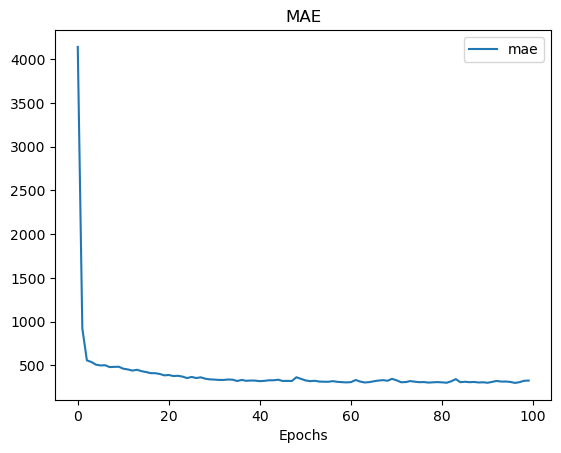

In [182]:
train_windows, test_windows, train_labels, test_labels = prepdata(horizon=1, window=7)
conv1d(train_windows, train_labels, test_windows, test_labels, 'model_conv1d_w7h1', horizon=1, window=7)

model_conv1d_w7h1 = tf.keras.models.load_model(os.path.join('model_experiments', 'model_conv1d_w7h1'))
model_conv1d_w7h1.evaluate(test_windows, test_labels)

model_conv1d_w7h1_preds = make_preds(model_conv1d_w7h1, test_windows)
model_conv1d_w7h1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_conv1d_w7h1_preds)
model_conv1d_w7h1_results, naive_results

In [175]:
len(train_windows), len(test_windows), len(train_labels), len(test_labels)
     


(2601, 651, 2601, 651)

In [176]:
model_conv1d_w7h1_preds[:10]

21/21 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10, 7), dtype=float32, numpy=
array([[61330.555, 61378.52 , 61618.98 , 61153.582, 61555.473, 61430.35 ,
        61425.3  ],
       [62986.64 , 62993.574, 63379.426, 62797.234, 63047.582, 63129.004,
        63064.746],
       [66965.516, 67043.414, 67430.13 , 66850.24 , 67122.44 , 67161.57 ,
        67060.89 ],
       [67092.84 , 66945.445, 67095.98 , 66623.56 , 67269.22 , 66893.99 ,
        67205.03 ],
       [65185.17 , 65164.723, 65401.945, 64841.73 , 65341.48 , 65167.74 ,
        65367.33 ],
       [64692.824, 64980.39 , 65359.598, 64847.535, 65081.367, 65177.055,
        64885.168],
       [64168.414, 64120.566, 64361.465, 63893.29 , 64345.098, 64175.008,
        64241.934],
       [64250.016, 64246.418, 64700.258, 64043.785, 64239.504, 64433.773,
        64342.21 ],
       [65083.83 , 65218.418, 65571.96 , 64997.27 , 65304.535, 65350.535,
        65219.457],
       [63650.26 , 63589.723, 63736.88 , 63245.637, 63843.387, 63548.727,
        63774.746]], dtype=floa

#### The Conv1D layer in TensorFlow takes an input of: (batch_size, timesteps, input_dim)
* timesteps = WINDOW_SIZE
* input_dim = HORIZON


In [139]:
train_windows[0].shape # (WINDOW_SIZE, )

(7,)

In [140]:
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[457.334]
 [424.44 ]
 [394.796]
 [408.904]
 [398.821]
 [402.152]
 [435.791]]


## 4.5 RNN - LSTM model  (window: 7, horizon: 1)

In [191]:
def lstm(train_windows, train_labels, test_windows, test_labels, name, window=None, horizon=None):
    tf.random.set_seed(42)

    # Construct model
    inputs = layers.Input(shape=(window))
    x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
    # print(x.shape)
    # x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
    x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
    # print(x.shape)
    # Add another optional dense layer (you could add more of these to see if they improve model performance)
    # x = layers.Dense(32, activation="relu")(x)
    output = layers.Dense(horizon)(x)
    model = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")


    # Compile model
    model.compile(loss="mae",
                    optimizer=tf.keras.optimizers.legacy.Adam(),
                    metrics=["mae", "mse"]) # we don't necessarily need this when the loss function is already MAE
    #model.summary()
    # Fit model
    history = model.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
                        y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
                        epochs=100,
                        verbose=1,
                        batch_size=128,
                        validation_data=(test_windows, test_labels),
                        callbacks=[create_model_checkpoint(model_name=model.name)]) # create ModelCheckpoint callback to save best model
    model.save(os.path.join('models', name))
    plot_loss_curves(history)
    return history

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 7381.5361 - mae: 7381.5361 - mse: 177835168.0000INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 3s 79ms/step - loss: 7381.5361 - mae: 7381.5361 - mse: 177835168.0000 - val_loss: 14213.6172 - val_mae: 14213.6172 - val_mse: 230365088.0000
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 2508.2922 - mae: 2508.2922 - mse: 27157944.0000INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 39ms/step - loss: 2508.2922 - mae: 2508.2922 - mse: 27157944.0000 - val_loss: 2288.9756 - val_mae: 2288.9756 - val_mse: 8364250.0000
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 742.7928 - mae: 742.7928 - mse: 2745901.2500INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 39ms/step - loss: 742.7928 - mae: 742.7928 - mse: 2745901.2500 - val_loss: 1182.5728 - val_mae: 1182.5728 - val_mse: 2753949.0000
Epoch 4/100
21/21 [==============================] - ETA: 0s - loss: 548.3002 - mae: 548.3002 - mse: 1570366.2500INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 40ms/step - loss: 548.3002 - mae: 548.3002 - mse: 1570366.2500 - val_loss: 1159.2214 - val_mae: 1159.2214 - val_mse: 2956401.0000
Epoch 5/100
19/21 [==========================>...] - ETA: 0s - loss: 526.3861 - mae: 526.3861 - mse: 1466573.6250INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 43ms/step - loss: 525.8893 - mae: 525.8893 - mse: 1471447.0000 - val_loss: 1139.6396 - val_mae: 1139.6396 - val_mse: 2879578.0000
Epoch 6/100
21/21 [==============================] - 0s 19ms/step - loss: 520.7310 - mae: 520.7310 - mse: 1445644.2500 - val_loss: 1218.0588 - val_mae: 1218.0588 - val_mse: 3158948.2500
Epoch 7/100
21/21 [==============================] - 0s 21ms/step - loss: 522.0544 - mae: 522.0544 - mse: 1451072.6250 - val_loss: 1179.3951 - val_mae: 1179.3951 - val_mse: 3004656.7500
Epoch 8/100
21/21 [==============================] - 0s 20ms/step - loss: 515.3121 - mae: 515.3121 - mse: 1412021.1250 - val_loss: 1158.2560 - val_mae: 1158.2560 - val_mse: 2917718.2500
Epoch 9/100
21/21 [==============================] - 0s 21ms/step - loss: 512.1766 - mae: 512.1766 - mse: 1400294.6250 - val_loss: 1174.7770 - val_mae: 1174.7770 - val_mse: 2968465.0000
Epoch 10/100
19/21 [==========================>...] - ETA: 0s - loss: 501.9727 - m

INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 43ms/step - loss: 509.8060 - mae: 509.8060 - mse: 1386506.0000 - val_loss: 1132.3933 - val_mae: 1132.3933 - val_mse: 2805689.5000
Epoch 11/100
21/21 [==============================] - 0s 19ms/step - loss: 504.2628 - mae: 504.2628 - mse: 1347993.7500 - val_loss: 1414.6174 - val_mae: 1414.6174 - val_mse: 3869139.2500
Epoch 12/100
21/21 [==============================] - 0s 18ms/step - loss: 515.9594 - mae: 515.9594 - mse: 1420467.8750 - val_loss: 1383.4247 - val_mae: 1383.4247 - val_mse: 3728334.7500
Epoch 13/100
19/21 [==========================>...] - ETA: 0s - loss: 505.9437 - mae: 505.9437 - mse: 1338196.6250INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 45ms/step - loss: 498.1666 - mae: 498.1666 - mse: 1326498.7500 - val_loss: 1035.9238 - val_mae: 1035.9238 - val_mse: 2414413.7500
Epoch 14/100
21/21 [==============================] - 0s 16ms/step - loss: 491.9070 - mae: 491.9070 - mse: 1268907.3750 - val_loss: 1076.9883 - val_mae: 1076.9883 - val_mse: 2541094.0000
Epoch 15/100
21/21 [==============================] - 0s 20ms/step - loss: 488.4625 - mae: 488.4625 - mse: 1272592.5000 - val_loss: 1375.5461 - val_mae: 1375.5461 - val_mse: 3600752.0000
Epoch 16/100
21/21 [==============================] - 0s 20ms/step - loss: 481.9534 - mae: 481.9534 - mse: 1248711.2500 - val_loss: 1317.2786 - val_mae: 1317.2786 - val_mse: 3359904.5000
Epoch 17/100
21/21 [==============================] - ETA: 0s - loss: 481.4537 - mae: 481.4537 - mse: 1249331.5000INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 38ms/step - loss: 481.4537 - mae: 481.4537 - mse: 1249331.5000 - val_loss: 991.2502 - val_mae: 991.2502 - val_mse: 2224055.7500
Epoch 18/100
21/21 [==============================] - 0s 16ms/step - loss: 459.1581 - mae: 459.1581 - mse: 1111369.3750 - val_loss: 1084.5317 - val_mae: 1084.5317 - val_mse: 2512176.5000
Epoch 19/100
18/21 [========================>.....] - ETA: 0s - loss: 460.0169 - mae: 460.0169 - mse: 1127738.5000INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 36ms/step - loss: 455.7298 - mae: 455.7298 - mse: 1105806.7500 - val_loss: 990.6634 - val_mae: 990.6634 - val_mse: 2204564.7500
Epoch 20/100
21/21 [==============================] - 0s 16ms/step - loss: 451.6730 - mae: 451.6730 - mse: 1077640.5000 - val_loss: 1037.8710 - val_mae: 1037.8710 - val_mse: 2340247.5000
Epoch 21/100
21/21 [==============================] - ETA: 0s - loss: 456.0583 - mae: 456.0583 - mse: 1082493.0000INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 37ms/step - loss: 456.0583 - mae: 456.0583 - mse: 1082493.0000 - val_loss: 919.3223 - val_mae: 919.3223 - val_mse: 1929115.8750
Epoch 22/100
21/21 [==============================] - 0s 15ms/step - loss: 446.7246 - mae: 446.7246 - mse: 1056218.1250 - val_loss: 1121.4180 - val_mae: 1121.4180 - val_mse: 2573135.0000
Epoch 23/100
21/21 [==============================] - ETA: 0s - loss: 437.3666 - mae: 437.3666 - mse: 1012930.1875INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 60ms/step - loss: 437.3666 - mae: 437.3666 - mse: 1012930.1875 - val_loss: 914.1417 - val_mae: 914.1417 - val_mse: 1929779.1250
Epoch 24/100
18/21 [========================>.....] - ETA: 0s - loss: 429.3604 - mae: 429.3604 - mse: 986942.0000 INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 36ms/step - loss: 431.5759 - mae: 431.5759 - mse: 996576.5000 - val_loss: 907.9961 - val_mae: 907.9961 - val_mse: 1902801.7500
Epoch 25/100
21/21 [==============================] - 0s 16ms/step - loss: 427.6292 - mae: 427.6292 - mse: 959864.7500 - val_loss: 1187.7675 - val_mae: 1187.7675 - val_mse: 2756494.0000
Epoch 26/100
21/21 [==============================] - 0s 16ms/step - loss: 439.0095 - mae: 439.0095 - mse: 989493.3750 - val_loss: 966.9196 - val_mae: 966.9196 - val_mse: 2052483.8750
Epoch 27/100
21/21 [==============================] - ETA: 0s - loss: 424.8699 - mae: 424.8699 - mse: 959596.8750INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 37ms/step - loss: 424.8699 - mae: 424.8699 - mse: 959596.8750 - val_loss: 887.9301 - val_mae: 887.9301 - val_mse: 1815879.3750
Epoch 28/100
21/21 [==============================] - 0s 16ms/step - loss: 422.4203 - mae: 422.4203 - mse: 953443.5000 - val_loss: 898.2759 - val_mae: 898.2759 - val_mse: 1836426.6250
Epoch 29/100
21/21 [==============================] - 0s 15ms/step - loss: 408.9769 - mae: 408.9769 - mse: 908944.1875 - val_loss: 1052.5851 - val_mae: 1052.5851 - val_mse: 2274101.2500
Epoch 30/100
21/21 [==============================] - ETA: 0s - loss: 408.5099 - mae: 408.5099 - mse: 894205.7500INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 37ms/step - loss: 408.5099 - mae: 408.5099 - mse: 894205.7500 - val_loss: 838.0826 - val_mae: 838.0826 - val_mse: 1645355.0000
Epoch 31/100
21/21 [==============================] - 0s 15ms/step - loss: 400.3435 - mae: 400.3435 - mse: 857059.9375 - val_loss: 915.1229 - val_mae: 915.1229 - val_mse: 1856971.7500
Epoch 32/100
21/21 [==============================] - 0s 18ms/step - loss: 393.5722 - mae: 393.5722 - mse: 833014.0625 - val_loss: 845.0201 - val_mae: 845.0201 - val_mse: 1654981.2500
Epoch 33/100
21/21 [==============================] - 0s 17ms/step - loss: 389.5106 - mae: 389.5106 - mse: 820585.5625 - val_loss: 863.6935 - val_mae: 863.6935 - val_mse: 1697934.7500
Epoch 34/100
18/21 [========================>.....] - ETA: 0s - loss: 387.6841 - mae: 387.6841 - mse: 821336.6875INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 42ms/step - loss: 384.5947 - mae: 384.5947 - mse: 794740.7500 - val_loss: 822.7095 - val_mae: 822.7095 - val_mse: 1581949.2500
Epoch 35/100
21/21 [==============================] - ETA: 0s - loss: 385.7984 - mae: 385.7984 - mse: 795796.3125INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 39ms/step - loss: 385.7984 - mae: 385.7984 - mse: 795796.3125 - val_loss: 798.1072 - val_mae: 798.1072 - val_mse: 1484573.2500
Epoch 36/100
21/21 [==============================] - 0s 17ms/step - loss: 380.7677 - mae: 380.7677 - mse: 786337.5000 - val_loss: 804.0309 - val_mae: 804.0309 - val_mse: 1517765.5000
Epoch 37/100
21/21 [==============================] - 0s 17ms/step - loss: 376.9458 - mae: 376.9458 - mse: 764425.6875 - val_loss: 814.6199 - val_mae: 814.6199 - val_mse: 1543685.3750
Epoch 38/100
21/21 [==============================] - 0s 19ms/step - loss: 370.3367 - mae: 370.3367 - mse: 741964.4375 - val_loss: 800.2267 - val_mae: 800.2267 - val_mse: 1499581.5000
Epoch 39/100
21/21 [==============================] - 0s 17ms/step - loss: 387.6339 - mae: 387.6339 - mse: 817411.6250 - val_loss: 876.5436 - val_mae: 876.5436 - val_mse: 1555713.3750
Epoch 40/100
21/21 [==============================] - 0s 20ms/step - loss: 375.4508 - mae: 37

INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 43ms/step - loss: 361.8790 - mae: 361.8790 - mse: 719566.3125 - val_loss: 769.6933 - val_mae: 769.6933 - val_mse: 1373355.2500
Epoch 42/100
21/21 [==============================] - 0s 19ms/step - loss: 363.1156 - mae: 363.1156 - mse: 726160.5000 - val_loss: 820.2153 - val_mae: 820.2153 - val_mse: 1529084.0000
Epoch 43/100
21/21 [==============================] - 0s 19ms/step - loss: 354.0137 - mae: 354.0137 - mse: 699190.9375 - val_loss: 822.4883 - val_mae: 822.4883 - val_mse: 1530360.5000
Epoch 44/100
21/21 [==============================] - 0s 18ms/step - loss: 359.5571 - mae: 359.5571 - mse: 710755.8750 - val_loss: 808.8188 - val_mae: 808.8188 - val_mse: 1396791.6250
Epoch 45/100
21/21 [==============================] - ETA: 0s - loss: 365.2397 - mae: 365.2397 - mse: 738233.8125INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 39ms/step - loss: 365.2397 - mae: 365.2397 - mse: 738233.8125 - val_loss: 761.4929 - val_mae: 761.4929 - val_mse: 1324471.5000
Epoch 46/100
21/21 [==============================] - 0s 16ms/step - loss: 360.1829 - mae: 360.1829 - mse: 712286.8125 - val_loss: 841.3819 - val_mae: 841.3819 - val_mse: 1569685.6250
Epoch 47/100
21/21 [==============================] - 0s 18ms/step - loss: 367.8648 - mae: 367.8648 - mse: 701237.5625 - val_loss: 1006.0667 - val_mae: 1006.0667 - val_mse: 2023318.3750
Epoch 48/100
20/21 [===========================>..] - ETA: 0s - loss: 364.7339 - mae: 364.7339 - mse: 718878.4375INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 42ms/step - loss: 366.0260 - mae: 366.0260 - mse: 727603.7500 - val_loss: 752.5846 - val_mae: 752.5846 - val_mse: 1301097.1250
Epoch 49/100
20/21 [===========================>..] - ETA: 0s - loss: 355.6526 - mae: 355.6526 - mse: 711984.2500INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 40ms/step - loss: 355.9055 - mae: 355.9055 - mse: 713031.7500 - val_loss: 745.5749 - val_mae: 745.5749 - val_mse: 1296574.3750
Epoch 50/100
21/21 [==============================] - 0s 17ms/step - loss: 341.4219 - mae: 341.4219 - mse: 653162.4375 - val_loss: 828.5179 - val_mae: 828.5179 - val_mse: 1525902.5000
Epoch 51/100
21/21 [==============================] - 0s 17ms/step - loss: 341.0675 - mae: 341.0675 - mse: 643711.5000 - val_loss: 770.6823 - val_mae: 770.6823 - val_mse: 1375180.8750
Epoch 52/100
21/21 [==============================] - 0s 17ms/step - loss: 341.5392 - mae: 341.5392 - mse: 651481.3125 - val_loss: 782.1084 - val_mae: 782.1084 - val_mse: 1320553.6250
Epoch 53/100
21/21 [==============================] - 0s 17ms/step - loss: 349.8043 - mae: 349.8043 - mse: 675221.0000 - val_loss: 902.7553 - val_mae: 902.7553 - val_mse: 1718976.1250
Epoch 54/100
21/21 [==============================] - ETA: 0s - loss: 343.9913 - mae: 343.991

INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 40ms/step - loss: 343.9913 - mae: 343.9913 - mse: 644291.5625 - val_loss: 736.2528 - val_mae: 736.2528 - val_mse: 1269027.6250
Epoch 55/100
21/21 [==============================] - ETA: 0s - loss: 340.8520 - mae: 340.8520 - mse: 643452.6875INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 38ms/step - loss: 340.8520 - mae: 340.8520 - mse: 643452.6875 - val_loss: 735.3937 - val_mae: 735.3937 - val_mse: 1260010.8750
Epoch 56/100
21/21 [==============================] - 0s 15ms/step - loss: 347.2453 - mae: 347.2453 - mse: 668235.0625 - val_loss: 748.4343 - val_mae: 748.4343 - val_mse: 1310007.6250
Epoch 57/100
21/21 [==============================] - 0s 16ms/step - loss: 360.1337 - mae: 360.1337 - mse: 692454.1875 - val_loss: 925.7996 - val_mae: 925.7996 - val_mse: 1770457.1250
Epoch 58/100
19/21 [==========================>...] - ETA: 0s - loss: 341.1253 - mae: 341.1253 - mse: 655131.5625INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 42ms/step - loss: 338.4247 - mae: 338.4247 - mse: 643270.9375 - val_loss: 733.0066 - val_mae: 733.0066 - val_mse: 1261234.6250
Epoch 59/100
21/21 [==============================] - 0s 17ms/step - loss: 334.7964 - mae: 334.7964 - mse: 635655.7500 - val_loss: 738.2770 - val_mae: 738.2770 - val_mse: 1278880.1250
Epoch 60/100
21/21 [==============================] - ETA: 0s - loss: 330.6517 - mae: 330.6517 - mse: 623027.5000INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 40ms/step - loss: 330.6517 - mae: 330.6517 - mse: 623027.5000 - val_loss: 729.5909 - val_mae: 729.5909 - val_mse: 1246955.2500
Epoch 61/100
21/21 [==============================] - 0s 18ms/step - loss: 331.9634 - mae: 331.9634 - mse: 612499.8125 - val_loss: 747.8204 - val_mae: 747.8204 - val_mse: 1247498.8750
Epoch 62/100
21/21 [==============================] - 0s 17ms/step - loss: 347.9882 - mae: 347.9882 - mse: 670011.1250 - val_loss: 737.1343 - val_mae: 737.1343 - val_mse: 1232979.5000
Epoch 63/100
21/21 [==============================] - 0s 17ms/step - loss: 359.6271 - mae: 359.6271 - mse: 711564.9375 - val_loss: 762.1494 - val_mae: 762.1494 - val_mse: 1337113.6250
Epoch 64/100
21/21 [==============================] - 0s 16ms/step - loss: 329.8743 - mae: 329.8743 - mse: 618517.0625 - val_loss: 744.5630 - val_mae: 744.5630 - val_mse: 1290968.8750
Epoch 65/100
21/21 [==============================] - ETA: 0s - loss: 329.0880 - mae: 329.088

INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 38ms/step - loss: 329.0880 - mae: 329.0880 - mse: 611826.3125 - val_loss: 723.4806 - val_mae: 723.4806 - val_mse: 1222742.5000
Epoch 66/100
21/21 [==============================] - 0s 17ms/step - loss: 335.7213 - mae: 335.7213 - mse: 629828.3750 - val_loss: 797.7242 - val_mae: 797.7242 - val_mse: 1319559.6250
Epoch 67/100
20/21 [===========================>..] - ETA: 0s - loss: 341.8996 - mae: 341.8996 - mse: 634243.0000INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 67ms/step - loss: 340.3202 - mae: 340.3202 - mse: 629344.5000 - val_loss: 723.2441 - val_mae: 723.2441 - val_mse: 1228888.5000
Epoch 68/100
21/21 [==============================] - 0s 18ms/step - loss: 327.4315 - mae: 327.4315 - mse: 614237.3125 - val_loss: 737.8723 - val_mae: 737.8723 - val_mse: 1220587.7500
Epoch 69/100
21/21 [==============================] - 0s 17ms/step - loss: 332.6435 - mae: 332.6435 - mse: 620838.3125 - val_loss: 738.7789 - val_mae: 738.7789 - val_mse: 1272978.7500
Epoch 70/100
21/21 [==============================] - ETA: 0s - loss: 328.8072 - mae: 328.8072 - mse: 618307.3125INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 39ms/step - loss: 328.8072 - mae: 328.8072 - mse: 618307.3125 - val_loss: 718.6068 - val_mae: 718.6068 - val_mse: 1211266.1250
Epoch 71/100
21/21 [==============================] - 0s 17ms/step - loss: 326.4027 - mae: 326.4027 - mse: 615030.9375 - val_loss: 733.3082 - val_mae: 733.3082 - val_mse: 1257441.8750
Epoch 72/100
21/21 [==============================] - 0s 16ms/step - loss: 327.8458 - mae: 327.8458 - mse: 613977.6875 - val_loss: 727.7408 - val_mae: 727.7408 - val_mse: 1200961.1250
Epoch 73/100
21/21 [==============================] - 0s 16ms/step - loss: 338.1171 - mae: 338.1171 - mse: 639931.8125 - val_loss: 736.6566 - val_mae: 736.6566 - val_mse: 1209681.3750
Epoch 74/100
21/21 [==============================] - ETA: 0s - loss: 324.2911 - mae: 324.2911 - mse: 600795.5625INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 39ms/step - loss: 324.2911 - mae: 324.2911 - mse: 600795.5625 - val_loss: 714.4964 - val_mae: 714.4964 - val_mse: 1194954.3750
Epoch 75/100
21/21 [==============================] - 0s 17ms/step - loss: 323.6121 - mae: 323.6121 - mse: 600323.5625 - val_loss: 787.9023 - val_mae: 787.9023 - val_mse: 1388823.5000
Epoch 76/100
21/21 [==============================] - 0s 16ms/step - loss: 324.4447 - mae: 324.4447 - mse: 602727.5000 - val_loss: 722.2420 - val_mae: 722.2420 - val_mse: 1187856.3750
Epoch 77/100
21/21 [==============================] - ETA: 0s - loss: 328.7733 - mae: 328.7733 - mse: 614462.2500INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 37ms/step - loss: 328.7733 - mae: 328.7733 - mse: 614462.2500 - val_loss: 711.4950 - val_mae: 711.4950 - val_mse: 1181780.0000
Epoch 78/100
21/21 [==============================] - 0s 15ms/step - loss: 335.0925 - mae: 335.0925 - mse: 625716.9375 - val_loss: 739.0934 - val_mae: 739.0934 - val_mse: 1204545.5000
Epoch 79/100
21/21 [==============================] - 0s 16ms/step - loss: 321.7463 - mae: 321.7463 - mse: 593435.0000 - val_loss: 719.0986 - val_mae: 719.0986 - val_mse: 1218018.2500
Epoch 80/100
21/21 [==============================] - 0s 16ms/step - loss: 323.2695 - mae: 323.2695 - mse: 600767.8750 - val_loss: 718.5237 - val_mae: 718.5237 - val_mse: 1176682.7500
Epoch 81/100
21/21 [==============================] - 0s 16ms/step - loss: 323.2478 - mae: 323.2478 - mse: 602354.2500 - val_loss: 725.5305 - val_mae: 725.5305 - val_mse: 1182731.3750
Epoch 82/100
21/21 [==============================] - 0s 16ms/step - loss: 320.5532 - mae: 32

INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 37ms/step - loss: 325.7566 - mae: 325.7566 - mse: 612209.1875 - val_loss: 705.8497 - val_mae: 705.8497 - val_mse: 1173526.5000
Epoch 84/100
21/21 [==============================] - 0s 15ms/step - loss: 334.3063 - mae: 334.3063 - mse: 624098.8125 - val_loss: 705.9090 - val_mae: 705.9090 - val_mse: 1177023.1250
Epoch 85/100
21/21 [==============================] - ETA: 0s - loss: 326.5563 - mae: 326.5563 - mse: 617874.6250INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 37ms/step - loss: 326.5563 - mae: 326.5563 - mse: 617874.6250 - val_loss: 703.7672 - val_mae: 703.7672 - val_mse: 1160769.1250
Epoch 86/100
21/21 [==============================] - ETA: 0s - loss: 319.7711 - mae: 319.7711 - mse: 587687.1875INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 39ms/step - loss: 319.7711 - mae: 319.7711 - mse: 587687.1875 - val_loss: 702.4706 - val_mae: 702.4706 - val_mse: 1161107.7500
Epoch 87/100
21/21 [==============================] - ETA: 0s - loss: 327.6378 - mae: 327.6378 - mse: 600242.3750INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 38ms/step - loss: 327.6378 - mae: 327.6378 - mse: 600242.3750 - val_loss: 701.8207 - val_mae: 701.8207 - val_mse: 1155960.5000
Epoch 88/100
21/21 [==============================] - 0s 17ms/step - loss: 330.6771 - mae: 330.6771 - mse: 618085.0625 - val_loss: 702.4124 - val_mae: 702.4124 - val_mse: 1168706.8750
Epoch 89/100
21/21 [==============================] - 0s 16ms/step - loss: 326.7039 - mae: 326.7039 - mse: 606653.6875 - val_loss: 754.6207 - val_mae: 754.6207 - val_mse: 1298694.5000
Epoch 90/100
21/21 [==============================] - 0s 16ms/step - loss: 330.0481 - mae: 330.0481 - mse: 603617.9375 - val_loss: 711.9300 - val_mae: 711.9300 - val_mse: 1154056.1250
Epoch 91/100
21/21 [==============================] - ETA: 0s - loss: 324.2455 - mae: 324.2455 - mse: 598278.6875INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 38ms/step - loss: 324.2455 - mae: 324.2455 - mse: 598278.6875 - val_loss: 698.0039 - val_mae: 698.0039 - val_mse: 1153122.0000
Epoch 92/100
21/21 [==============================] - 0s 16ms/step - loss: 318.2361 - mae: 318.2361 - mse: 589951.6250 - val_loss: 840.8959 - val_mae: 840.8959 - val_mse: 1496159.2500
Epoch 93/100
21/21 [==============================] - 0s 17ms/step - loss: 317.8186 - mae: 317.8186 - mse: 572554.3125 - val_loss: 806.6080 - val_mae: 806.6080 - val_mse: 1415161.7500
Epoch 94/100
21/21 [==============================] - 0s 16ms/step - loss: 317.4838 - mae: 317.4838 - mse: 584745.1250 - val_loss: 719.2726 - val_mae: 719.2726 - val_mse: 1157021.6250
Epoch 95/100
21/21 [==============================] - 0s 16ms/step - loss: 344.3154 - mae: 344.3154 - mse: 642867.2500 - val_loss: 714.8116 - val_mae: 714.8116 - val_mse: 1150654.3750
Epoch 96/100
21/21 [==============================] - 0s 17ms/step - loss: 333.0137 - mae: 33

INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


21/21 [==============================] - 1s 39ms/step - loss: 316.1168 - mae: 316.1168 - mse: 579623.3750 - val_loss: 691.7729 - val_mae: 691.7729 - val_mse: 1129890.2500
Epoch 99/100
21/21 [==============================] - 0s 17ms/step - loss: 319.1609 - mae: 319.1609 - mse: 584476.9375 - val_loss: 893.9767 - val_mae: 893.9767 - val_mse: 1619704.8750
Epoch 100/100
21/21 [==============================] - 0s 17ms/step - loss: 331.0929 - mae: 331.0929 - mse: 619269.2500 - val_loss: 704.8279 - val_mae: 704.8279 - val_mse: 1179188.5000
INFO:tensorflow:Assets written to: models/model_5_lstm/assets


INFO:tensorflow:Assets written to: models/model_5_lstm/assets


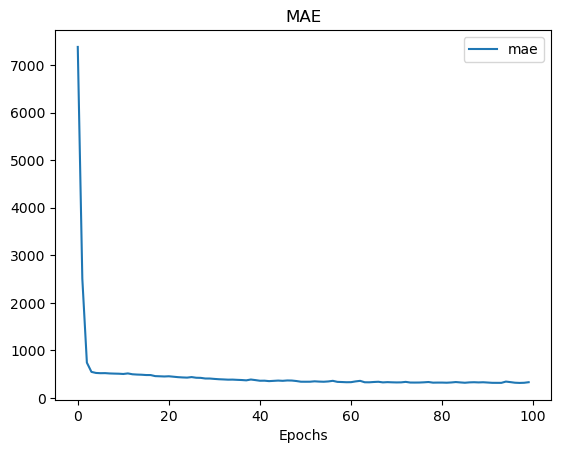

In [192]:
train_windows, test_windows, train_labels, test_labels = prepdata(horizon=1, window=7)
lstm(train_windows, train_labels, test_windows, test_labels, 'model_5_lstm', horizon=1, window=7)

In [193]:
model_5_lstm = tf.keras.models.load_model(os.path.join('model_experiments', 'model_5_lstm'))
model_5_lstm.evaluate(test_windows, test_labels)

model_5_lstm_preds = make_preds(model_5_lstm, test_windows)
model_5_lstm_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_lstm_preds)
model_5_lstm_results, naive_results

21/21 [==============================] - 0s 6ms/step


({'mae': 691.77295,
  'mse': 1129890.2,
  'rmse': 1062.963,
  'mape': 2.2491484,
  'mase': 1.1051049},
 {'mae': 627.78204,
  'mse': 976222.0,
  'rmse': 988.0395,
  'mape': 2.0496292,
  'mase': 1.0028796})

# Add another variable (Block reward)

In [194]:
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [196]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [197]:
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(661, 2063)

In [199]:
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2014-09-17,457.334015,25
2014-09-18,424.440002,25
2014-09-19,394.795990,25
2014-09-20,408.903992,25
2014-09-21,398.821014,25


In [200]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2023-08-15,29170.347656,6.25
2023-08-16,28701.779297,6.25
2023-08-17,26664.550781,6.25
2023-08-18,26049.556641,6.25
2023-08-20,26186.179688,6.25


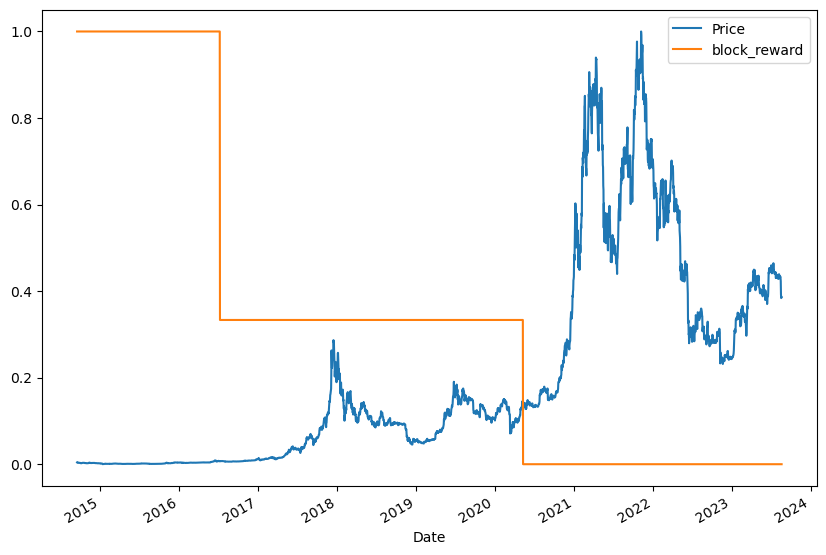

In [201]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## 4.6 Dense - Multivariate  (window: 7, horizon: 1)

In [226]:
def dense_mul(X_train, X_test, y_train, y_test, name, window=None, horizon=None):
    tf.random.set_seed(42)

    # Construct model
    model = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
      layers.Dense(horizon)
    ], name="model_6_dense_multivariate")


    # Compile model
    model.compile(loss="mae",
                    optimizer=tf.keras.optimizers.legacy.Adam(),
                    metrics=["mae", "mse"]) # we don't necessarily need this when the loss function is already MAE
    #model.summary()
    # Fit model
    model.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model.name)])
    model.save(os.path.join('models', name))
    plot_loss_curves(history)
    return history

In [227]:
X_train, X_test, y_train, y_test = prepdata_multivariate(bitcoin_prices_block, 
                                                         horizon=1, window=7)

dense_mul(X_train, X_test, y_train, y_test, 
          'model_6_dense_multivariate', 
          horizon=1, window=7)



Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 3945.3079 - mae: 3945.3079 - mse: 78282000.0000INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 1s 21ms/step - loss: 3945.3079 - mae: 3945.3079 - mse: 78282000.0000 - val_loss: 4612.2446 - val_mae: 4612.2446 - val_mse: 27677962.0000
Epoch 2/100
18/21 [========================>.....] - ETA: 0s - loss: 794.7355 - mae: 794.7355 - mse: 2852867.0000 INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 15ms/step - loss: 771.2011 - mae: 771.2011 - mse: 2708415.2500 - val_loss: 1782.2275 - val_mae: 1782.2275 - val_mse: 5513517.5000
Epoch 3/100
19/21 [==========================>...] - ETA: 0s - loss: 522.4799 - mae: 522.4799 - mse: 1427851.1250INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 14ms/step - loss: 521.6661 - mae: 521.6661 - mse: 1422425.6250 - val_loss: 1188.8777 - val_mae: 1188.8777 - val_mse: 2933139.7500
Epoch 4/100
19/21 [==========================>...] - ETA: 0s - loss: 513.7684 - mae: 513.7684 - mse: 1350983.7500INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 14ms/step - loss: 506.9716 - mae: 506.9716 - mse: 1318002.6250 - val_loss: 1028.0547 - val_mae: 1028.0547 - val_mse: 2330998.0000
Epoch 5/100
19/21 [==========================>...] - ETA: 0s - loss: 459.1934 - mae: 459.1934 - mse: 1130899.0000INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 15ms/step - loss: 463.7592 - mae: 463.7592 - mse: 1151324.8750 - val_loss: 985.4496 - val_mae: 985.4496 - val_mse: 2153214.5000
Epoch 6/100
21/21 [==============================] - 0s 8ms/step - loss: 449.4048 - mae: 449.4048 - mse: 1100548.6250 - val_loss: 992.0228 - val_mae: 992.0228 - val_mse: 2131022.5000
Epoch 7/100
20/21 [===========================>..] - ETA: 0s - loss: 434.3318 - mae: 434.3318 - mse: 1007430.1875INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 14ms/step - loss: 438.9602 - mae: 438.9602 - mse: 1026678.3125 - val_loss: 873.6069 - val_mae: 873.6069 - val_mse: 1658182.6250
Epoch 8/100
19/21 [==========================>...] - ETA: 0s - loss: 406.3086 - mae: 406.3086 - mse: 889865.6875 INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 14ms/step - loss: 407.7344 - mae: 407.7344 - mse: 906207.6250 - val_loss: 856.8096 - val_mae: 856.8096 - val_mse: 1565186.3750
Epoch 9/100
19/21 [==========================>...] - ETA: 0s - loss: 428.9005 - mae: 428.9005 - mse: 959221.8750INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 15ms/step - loss: 421.1183 - mae: 421.1183 - mse: 932107.6875 - val_loss: 810.8600 - val_mae: 810.8600 - val_mse: 1450826.3750
Epoch 10/100
20/21 [===========================>..] - ETA: 0s - loss: 378.5835 - mae: 378.5835 - mse: 779457.6875INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 14ms/step - loss: 380.6876 - mae: 380.6876 - mse: 788037.0000 - val_loss: 773.8611 - val_mae: 773.8611 - val_mse: 1390003.8750
Epoch 11/100
21/21 [==============================] - 0s 7ms/step - loss: 380.9349 - mae: 380.9349 - mse: 761038.8125 - val_loss: 1215.4532 - val_mae: 1215.4532 - val_mse: 2678468.2500
Epoch 12/100
20/21 [===========================>..] - ETA: 0s - loss: 355.3968 - mae: 355.3968 - mse: 709623.3125INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 14ms/step - loss: 355.6469 - mae: 355.6469 - mse: 707133.3750 - val_loss: 747.5377 - val_mae: 747.5377 - val_mse: 1278737.6250
Epoch 13/100
21/21 [==============================] - 0s 8ms/step - loss: 348.4398 - mae: 348.4398 - mse: 670592.8125 - val_loss: 765.0806 - val_mae: 765.0806 - val_mse: 1277347.3750
Epoch 14/100
21/21 [==============================] - 0s 8ms/step - loss: 340.4823 - mae: 340.4823 - mse: 646183.0625 - val_loss: 834.7173 - val_mae: 834.7173 - val_mse: 1529804.1250
Epoch 15/100
21/21 [==============================] - 0s 7ms/step - loss: 365.0958 - mae: 365.0958 - mse: 731576.6875 - val_loss: 856.1775 - val_mae: 856.1775 - val_mse: 1426952.0000
Epoch 16/100
21/21 [==============================] - 0s 7ms/step - loss: 365.2941 - mae: 365.2941 - mse: 714694.6875 - val_loss: 1012.7654 - val_mae: 1012.7654 - val_mse: 1997225.1250
Epoch 17/100
21/21 [==============================] - 0s 7ms/step - loss: 337.0279 - mae: 337.0

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 14ms/step - loss: 338.1181 - mae: 338.1181 - mse: 655565.8125 - val_loss: 721.0690 - val_mae: 721.0690 - val_mse: 1219390.7500
Epoch 22/100
21/21 [==============================] - 0s 7ms/step - loss: 343.6756 - mae: 343.6756 - mse: 657823.7500 - val_loss: 1040.3431 - val_mae: 1040.3431 - val_mse: 2041598.6250
Epoch 23/100
21/21 [==============================] - ETA: 0s - loss: 335.2940 - mae: 335.2940 - mse: 625423.0000INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 15ms/step - loss: 335.2940 - mae: 335.2940 - mse: 625423.0000 - val_loss: 698.1169 - val_mae: 698.1169 - val_mse: 1144713.3750
Epoch 24/100
21/21 [==============================] - 0s 10ms/step - loss: 331.1273 - mae: 331.1273 - mse: 614315.8125 - val_loss: 753.5828 - val_mae: 753.5828 - val_mse: 1292258.2500
Epoch 25/100
21/21 [==============================] - 0s 9ms/step - loss: 330.2676 - mae: 330.2676 - mse: 614145.7500 - val_loss: 1233.6267 - val_mae: 1233.6267 - val_mse: 2615789.7500
Epoch 26/100
21/21 [==============================] - 0s 10ms/step - loss: 347.6296 - mae: 347.6296 - mse: 644988.6250 - val_loss: 935.2182 - val_mae: 935.2182 - val_mse: 1575495.3750
Epoch 27/100
21/21 [==============================] - 0s 9ms/step - loss: 407.7944 - mae: 407.7944 - mse: 849003.7500 - val_loss: 806.7657 - val_mae: 806.7657 - val_mse: 1291101.5000
Epoch 28/100
21/21 [==============================] - 0s 8ms/step - loss: 322.7364 - mae: 322

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 15ms/step - loss: 314.2190 - mae: 314.2190 - mse: 567775.9375 - val_loss: 696.6273 - val_mae: 696.6273 - val_mse: 1097661.8750
Epoch 33/100
19/21 [==========================>...] - ETA: 0s - loss: 320.5190 - mae: 320.5190 - mse: 591720.3750INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 15ms/step - loss: 318.6714 - mae: 318.6714 - mse: 585348.1875 - val_loss: 672.5037 - val_mae: 672.5037 - val_mse: 1083902.8750
Epoch 34/100
21/21 [==============================] - 0s 8ms/step - loss: 317.0838 - mae: 317.0838 - mse: 565350.5625 - val_loss: 850.5057 - val_mae: 850.5057 - val_mse: 1504667.7500
Epoch 35/100
19/21 [==========================>...] - ETA: 0s - loss: 373.8707 - mae: 373.8707 - mse: 723229.3750INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 15ms/step - loss: 371.9438 - mae: 371.9438 - mse: 714671.6875 - val_loss: 669.2712 - val_mae: 669.2712 - val_mse: 1070899.3750
Epoch 36/100
21/21 [==============================] - 0s 8ms/step - loss: 324.7852 - mae: 324.7852 - mse: 607329.1250 - val_loss: 1017.4886 - val_mae: 1017.4886 - val_mse: 1932926.3750
Epoch 37/100
21/21 [==============================] - 0s 8ms/step - loss: 314.8180 - mae: 314.8180 - mse: 554964.8125 - val_loss: 680.2231 - val_mae: 680.2231 - val_mse: 1069828.3750
Epoch 38/100
21/21 [==============================] - 0s 8ms/step - loss: 313.5432 - mae: 313.5432 - mse: 556783.3750 - val_loss: 739.8206 - val_mae: 739.8206 - val_mse: 1242682.5000
Epoch 39/100
19/21 [==========================>...] - ETA: 0s - loss: 306.3253 - mae: 306.3253 - mse: 547161.8125INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 15ms/step - loss: 307.5869 - mae: 307.5869 - mse: 546800.8750 - val_loss: 665.8726 - val_mae: 665.8726 - val_mse: 1055564.5000
Epoch 40/100
21/21 [==============================] - 0s 8ms/step - loss: 312.1266 - mae: 312.1266 - mse: 559616.0000 - val_loss: 677.1926 - val_mae: 677.1926 - val_mse: 1059625.5000
Epoch 41/100
21/21 [==============================] - 0s 8ms/step - loss: 309.3277 - mae: 309.3277 - mse: 570485.3125 - val_loss: 719.2751 - val_mae: 719.2751 - val_mse: 1112599.3750
Epoch 42/100
21/21 [==============================] - 0s 8ms/step - loss: 306.2152 - mae: 306.2152 - mse: 547476.6250 - val_loss: 820.9590 - val_mae: 820.9590 - val_mse: 1422031.8750
Epoch 43/100
21/21 [==============================] - 0s 7ms/step - loss: 305.5921 - mae: 305.5921 - mse: 548026.8750 - val_loss: 679.2521 - val_mae: 679.2521 - val_mse: 1103447.2500
Epoch 44/100
21/21 [==============================] - 0s 8ms/step - loss: 310.4539 - mae: 310.453

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 14ms/step - loss: 317.0367 - mae: 317.0367 - mse: 551878.8750 - val_loss: 656.1042 - val_mae: 656.1042 - val_mse: 1037041.8125
Epoch 46/100
21/21 [==============================] - 0s 7ms/step - loss: 308.4701 - mae: 308.4701 - mse: 555050.3125 - val_loss: 717.7966 - val_mae: 717.7966 - val_mse: 1102492.3750
Epoch 47/100
21/21 [==============================] - 0s 7ms/step - loss: 308.3067 - mae: 308.3067 - mse: 552132.1875 - val_loss: 657.8912 - val_mae: 657.8912 - val_mse: 1053857.6250
Epoch 48/100
21/21 [==============================] - 0s 7ms/step - loss: 298.1852 - mae: 298.1852 - mse: 539723.5625 - val_loss: 777.4768 - val_mae: 777.4768 - val_mse: 1201626.3750
Epoch 49/100
21/21 [==============================] - 0s 7ms/step - loss: 368.8013 - mae: 368.8013 - mse: 659574.7500 - val_loss: 1127.0105 - val_mae: 1127.0105 - val_mse: 2220378.0000
Epoch 50/100
21/21 [==============================] - 0s 7ms/step - loss: 327.2208 - mae: 327.2

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 14ms/step - loss: 310.4553 - mae: 310.4553 - mse: 550927.0000 - val_loss: 646.2805 - val_mae: 646.2805 - val_mse: 1014382.8750
Epoch 60/100
21/21 [==============================] - 0s 7ms/step - loss: 302.0971 - mae: 302.0971 - mse: 538547.9375 - val_loss: 650.3574 - val_mae: 650.3574 - val_mse: 1014048.6250
Epoch 61/100
21/21 [==============================] - 0s 7ms/step - loss: 303.7726 - mae: 303.7726 - mse: 535361.2500 - val_loss: 788.1642 - val_mae: 788.1642 - val_mse: 1217071.0000
Epoch 62/100
21/21 [==============================] - 0s 7ms/step - loss: 302.6864 - mae: 302.6864 - mse: 535645.6875 - val_loss: 697.6503 - val_mae: 697.6503 - val_mse: 1063361.1250
Epoch 63/100
21/21 [==============================] - 0s 7ms/step - loss: 313.6149 - mae: 313.6149 - mse: 559687.5625 - val_loss: 676.5405 - val_mae: 676.5405 - val_mse: 1092037.5000
Epoch 64/100
21/21 [==============================] - ETA: 0s - loss: 309.5768 - mae: 309.5768 - 

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 14ms/step - loss: 309.5768 - mae: 309.5768 - mse: 549169.1875 - val_loss: 642.1891 - val_mae: 642.1891 - val_mse: 1010102.7500
Epoch 65/100
21/21 [==============================] - 0s 7ms/step - loss: 299.1388 - mae: 299.1388 - mse: 533326.8125 - val_loss: 664.1062 - val_mae: 664.1062 - val_mse: 1021427.6875
Epoch 66/100
21/21 [==============================] - 0s 7ms/step - loss: 304.2551 - mae: 304.2551 - mse: 548706.1875 - val_loss: 694.7532 - val_mae: 694.7532 - val_mse: 1129028.0000
Epoch 67/100
21/21 [==============================] - 0s 7ms/step - loss: 312.5822 - mae: 312.5822 - mse: 567489.7500 - val_loss: 737.7360 - val_mae: 737.7360 - val_mse: 1122655.1250
Epoch 68/100
21/21 [==============================] - 0s 7ms/step - loss: 323.7362 - mae: 323.7362 - mse: 580161.0625 - val_loss: 839.8083 - val_mae: 839.8083 - val_mse: 1322013.5000
Epoch 69/100
21/21 [==============================] - 0s 7ms/step - loss: 314.2490 - mae: 314.249

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 14ms/step - loss: 361.1938 - mae: 361.1938 - mse: 706394.7500 - val_loss: 640.4019 - val_mae: 640.4019 - val_mse: 1001065.6875
Epoch 75/100
21/21 [==============================] - 0s 7ms/step - loss: 324.0749 - mae: 324.0749 - mse: 583611.3750 - val_loss: 655.3896 - val_mae: 655.3896 - val_mse: 1008850.8750
Epoch 76/100
21/21 [==============================] - 0s 7ms/step - loss: 300.9072 - mae: 300.9072 - mse: 533891.0625 - val_loss: 663.8449 - val_mae: 663.8449 - val_mse: 1017083.5000
Epoch 77/100
21/21 [==============================] - 0s 7ms/step - loss: 313.3310 - mae: 313.3310 - mse: 575475.5000 - val_loss: 744.7089 - val_mae: 744.7089 - val_mse: 1232294.3750
Epoch 78/100
21/21 [==============================] - 0s 7ms/step - loss: 323.7133 - mae: 323.7133 - mse: 588713.5625 - val_loss: 797.7410 - val_mae: 797.7410 - val_mse: 1347822.8750
Epoch 79/100
21/21 [==============================] - 0s 7ms/step - loss: 312.7193 - mae: 312.719

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


21/21 [==============================] - 0s 14ms/step - loss: 304.0650 - mae: 304.0650 - mse: 531110.7500 - val_loss: 635.2065 - val_mae: 635.2065 - val_mse: 998156.5625
Epoch 91/100
21/21 [==============================] - 0s 7ms/step - loss: 304.8744 - mae: 304.8744 - mse: 545354.1250 - val_loss: 1040.0383 - val_mae: 1040.0383 - val_mse: 1947741.0000
Epoch 92/100
21/21 [==============================] - 0s 7ms/step - loss: 322.5446 - mae: 322.5446 - mse: 577144.6250 - val_loss: 686.9421 - val_mae: 686.9421 - val_mse: 1104618.0000
Epoch 93/100
21/21 [==============================] - 0s 7ms/step - loss: 300.8144 - mae: 300.8144 - mse: 521753.0000 - val_loss: 645.4208 - val_mae: 645.4208 - val_mse: 994399.4375
Epoch 94/100
21/21 [==============================] - 0s 7ms/step - loss: 308.0397 - mae: 308.0397 - mse: 552188.3750 - val_loss: 844.4858 - val_mae: 844.4858 - val_mse: 1327190.3750
Epoch 95/100
21/21 [==============================] - 0s 7ms/step - loss: 301.8101 - mae: 301.810

INFO:tensorflow:Assets written to: models/model_6_dense_multivariate/assets


NameError: name 'history' is not defined

In [228]:
model_6_dense_multivariate = tf.keras.models.load_model(os.path.join('model_experiments', 'model_6_dense_multivariate'))
model_6_dense_multivariate.evaluate(X_test, y_test)

model_6_dense_multivariate_preds = make_preds(model_6_dense_multivariate, X_test)
model_6_dense_multivariate_results = evaluate_preds(y_true=tf.squeeze(y_test),
                                 y_pred=model_6_dense_multivariate_preds)
model_6_dense_multivariate_results, naive_results


21/21 [==============================] - 0s 2ms/step


({'mae': 635.2065,
  'mse': 998156.56,
  'rmse': 999.0779,
  'mape': 2.0695467,
  'mase': 1.0147402},
 {'mae': 627.78204,
  'mse': 976222.0,
  'rmse': 988.0395,
  'mape': 2.0496292,
  'mase': 1.0028796})

## 4.7 N-BEATS  (window: 7, horizon: 1)
https://arxiv.org/pdf/1905.10437.pdf

In [255]:
class NBeatsBlock(tf.keras.layers.Layer):
      def __init__(self,
                   input_size: int,
                   theta_size: int,
                   horizon: int,
                   n_neurons: int,
                   n_layers: int,
                   **kwargs): 
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

      def call(self, inputs): # the call method is what runs when the layer is called 
        x = inputs 
        for layer in self.hidden: # pass inputs through each hidden layer 
          x = layer(x)
        theta = self.theta_layer(x) 
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

In [251]:
HORIZON = 1
WINDOW_SIZE = 7

dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [252]:
tf.range(WINDOW_SIZE)


<tf.Tensor: shape=(7,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6], dtype=int32)>

In [253]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) 
# input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [254]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.08015239 -0.40879834 -0.32625076  0.12132621  0.52435774  0.3592998
  0.565379  ]
Forecast: 0.7252817153930664


In [259]:
def prepdata_nbeats():
    bitcoin_prices_nbeats = bitcoin_prices.copy()
    for i in range(WINDOW_SIZE):
        bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
    bitcoin_prices_nbeats.dropna().head()
    
    X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
    y = bitcoin_prices_nbeats.dropna()["Price"]

    # Make train and test sets
    split_size = int(len(X) * 0.8)
    X_train, y_train = X[:split_size], y[:split_size]
    X_test, y_test = X[split_size:], y[split_size:]
    
    return X_train, X_test, y_train, y_test
